# Clustering on iris dataset
---
Guidelines:
* Using the IRIS dataset, create the following algorithms:
  * Kmeans
  * DBSCAN
  * Hierarchical clustering
* After that, compare the results using ARI and Silhouette Score

## Initialization

In [123]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from typing import Union
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score
%config InlineBackend.figure_format = "retina"

In [124]:
color_a1 = '#664c85'
color_a2 = '#5b92b6'
color_a3 = '#52d5bd'
color_a4 = '#eeeeee'
palette_a1 = 'mako'
palette_a2 = 'mako_r'

### Dataset information

In [125]:
# Loading dataset from `sklearn.datasets.load_iris`
data_raw_iris = load_iris()

# Getting dataset information
print(f'Dataset keys: {data_raw_iris.keys()}\n')
print(data_raw_iris['DESCR'])

Dataset keys: dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (

#### Getting dataset target names or true clusters name

In [126]:
for target_name in data_raw_iris['target_names']:
    print(f"{np.where(data_raw_iris['target_names'] == target_name)[0]} {target_name}")

[0] setosa
[1] versicolor
[2] virginica


#### Mapping it into a dictionary

In [127]:
var_ground_truth_clusters_value_names = dict(
    zip(range(len(data_raw_iris['target_names'])), data_raw_iris['target_names']))
var_ground_truth_clusters_value_names

{0: 'setosa', 1: 'versicolor', 2: 'virginica'}

#### Making a dataframe out of the raw data and including the true values of the clusters for later on validation

In [128]:
df_iris = (
    pd.DataFrame(
        columns = data_raw_iris['feature_names'],
        data = data_raw_iris['data'],)
    .assign(ground_truth_cluster = data_raw_iris['target']))

df_iris

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     ground_truth_cluster  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  
..                    ...  
145                     2  
146                     2  
147                     2  
148                     2  
149                     2  

[150 rows x 5 columns]

#### Dataframe information and statistics

In [129]:
df_iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sepal length (cm)     150 non-null    float64
 1   sepal width (cm)      150 non-null    float64
 2   petal length (cm)     150 non-null    float64
 3   petal width (cm)      150 non-null    float64
 4   ground_truth_cluster  150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [130]:
df_iris.describe()

sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  ground_truth_cluster  
count        150.000000            150.000000  
mean           1.199333              1.000000  
std            0.762238              0.819232  
min            0.100000              0.000000  
25%            0.300000              0.000000  
50%            1.300000              1.000000  
75%            1.800000              2.000000  
max            2.500000              2.000000

#### Plotting iris dataset features distribution for later on deciding on standardization or normalization

In [131]:
def plot_pairplot(
    data, hue: str, labels: list[str],
    title: str = None, palette: Union[sns.color_palette, str] = None, 
) -> sns.pairplot:
  
    title = ' ' if title is None else title
    palette = sns.color_palette(palette_a1)[::2] if palette is None else palette
    
    sns.set(style = 'whitegrid')

    g = sns.pairplot(
        data = data, hue = hue, aspect = 2,
        height = 3, palette = palette)

    g.fig.suptitle(
        t = f'\n\n\n{title}'.upper(), y = 1.15, x = 0.02,
        horizontalalignment = 'left', fontsize = 20, fontweight = 'bold')

    for axes in g.axes:
        axes[0].set_ylabel(
            ylabel = "".join([('\n'*4), (axes[0].get_ylabel()), ('\n')]),
            fontdict = dict(fontsize = 15, fontweight = 'medium'))

    for axes in g.axes[3]:
        axes.set_xlabel(
            xlabel = "".join([('\n'), (axes.get_xlabel()), ('\n'*4)]),
            fontdict = dict(fontsize = 15, fontweight = 'medium'))    

    sns.move_legend(
        obj = g, loc = 'lower left', bbox_to_anchor = (0.01, 1.01), 
        ncol = 3, title = None, frameon = False,
        markerscale = 2,handles = g._legend_data.values(),
        labels = labels, prop = dict(size = 14, weight = 'medium'))

    plt.text(
        s = ' ', x = 1.2, y = 1,
        transform = g.axes[0, -1].transAxes)

    sns.despine()

    return g

/home/cabrera/anaconda3/envs/dsa/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


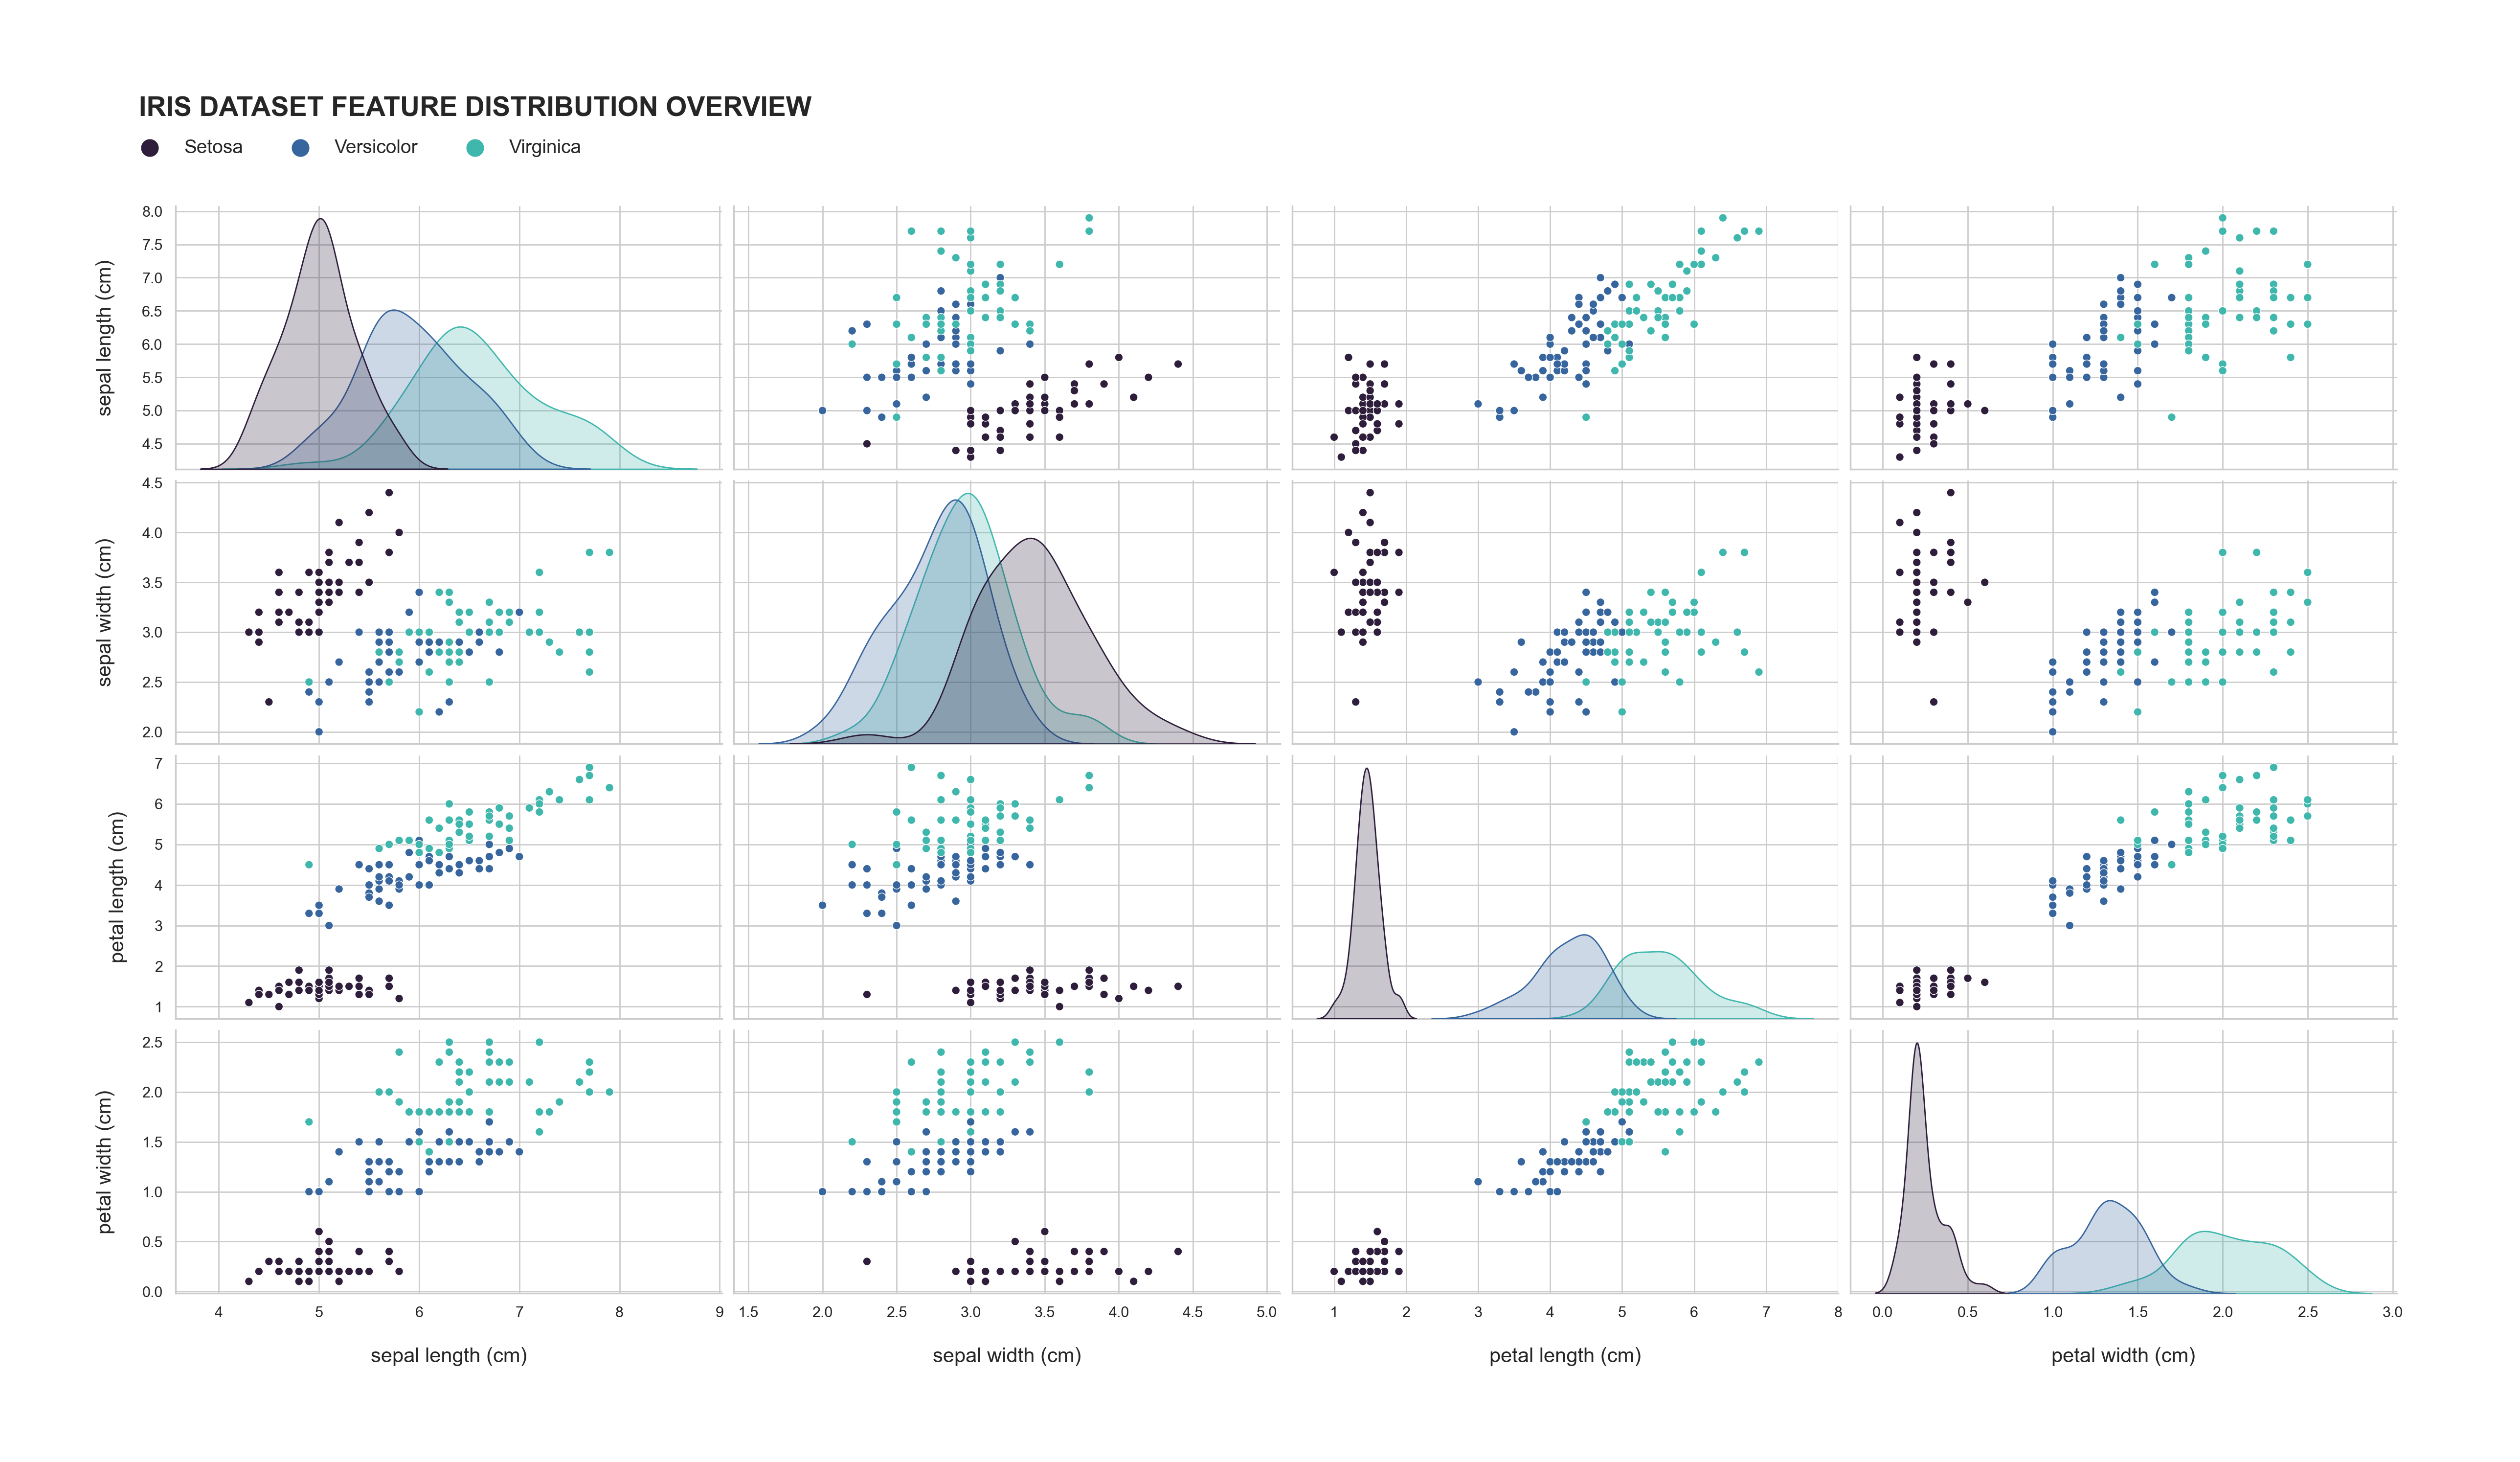

In [132]:
# Plotting the distribution overview
plot_pairplot(
    data = df_iris,
    hue = 'ground_truth_cluster',
    title = 'Iris Dataset Feature Distribution Overview',
    labels = [label.title() for label in var_ground_truth_clusters_value_names.values()]
);

#### Getting correlation overview

In [133]:
def plot_heatmap(
    data, title: str = None, subtitle: str = None, 
    x_label = None, y_label = None,
    cmap = sns.color_palette(palette = palette_a1, as_cmap = True),
) -> sns.heatmap:

    title = ' ' if title is None else title
    subtitle = ' ' if subtitle is None else subtitle
    x_label = ' ' if x_label is None else x_label
    y_label = ' ' if y_label is None else y_label

    sns.set(
        style = 'whitegrid',
        rc = {'figure.figsize': (16,4)})

    g = sns.heatmap(
        data = data, cmap = cmap, annot = True, 
        linewidth = 2,)

    g.set_ylabel("".join([('\n'*3), (y_label), ("\n"*1)]))
    g.set_xlabel("".join([('\n'*1), (x_label), ("\n"*3)]))

    g.set_title(
        "".join([(' '), ('\n'*4), (f'{title}'), ('\n'*2)]).upper(),
        loc = 'left',
        fontdict = dict(fontsize = 12, fontweight = 'bold'),)

    plt.text(
        s = f'{subtitle}', alpha = 0.5, x = 0,
        y = -.5, horizontalalignment = 'left',
        verticalalignment = 'top',)

    plt.text(
        s = ' ', x = 1.21, y = 1,
        transform = g.transAxes,)

    return g

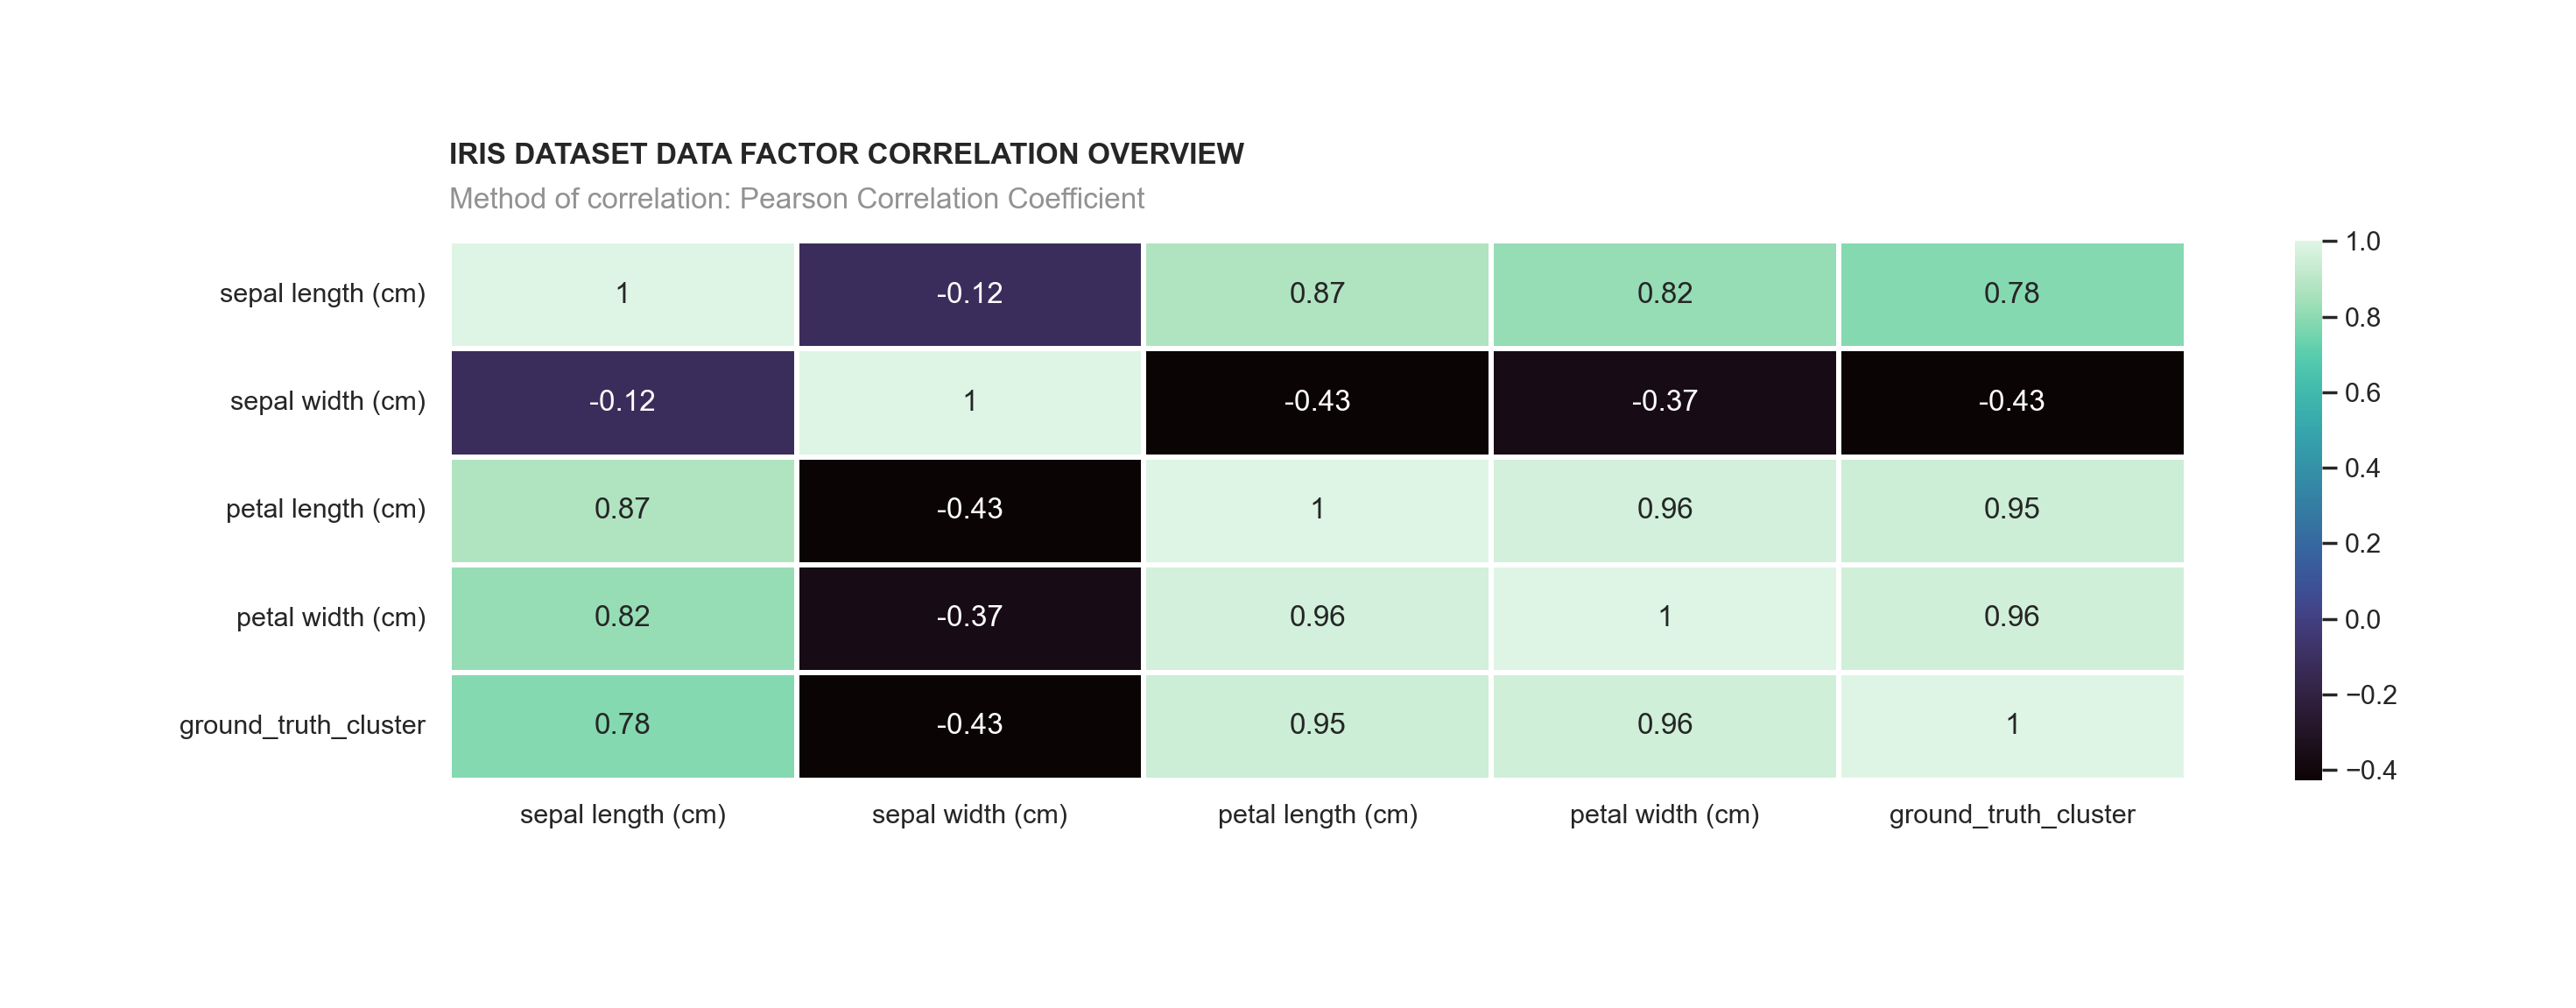

In [134]:
plot_heatmap(
    data = df_iris.corr(),
    title = 'Iris Dataset Data Factor Correlation Overview',
    subtitle = 'Method of correlation: Pearson Correlation Coefficient',
);

The Sepal Width feature shows to be not that helpful in explaining the target class outcome with its value of correlation with the ground truth cluster/classes or species of -0.43 as compared to the other features which got a correlation value of 0.78 and above

#### Frequency distribution of true cluster or species

In [135]:
(df_iris['ground_truth_cluster']
    .replace(var_ground_truth_clusters_value_names)
    .value_counts()
    .reset_index()
    .rename(columns = {'index': 'species/cluster', 'ground_truth_cluster': 'count'}))

species/cluster  count
0          setosa     50
1      versicolor     50
2       virginica     50

#### Saving the dataframe as csv and the raw data as binary file to local machine

In [136]:
def data_savetolocal() -> None:
    """Saves the dataframe and raw data to local machine."""
    # Check if the `cwd`/data directory does not exist first and create the directory if it is true
    if not os.path.exists(f'{os.getcwd()}/data'):
        os.mkdir('data')

    df_iris.to_csv('data/data_iris.csv')
    with open('data/data_iris.bin', 'wb') as file:
        pickle.dump(data_raw_iris, file)

data_savetolocal()

### Primary variables initialization

In [137]:
var_X = df_iris.iloc[:, :-1]
var_y = df_iris.iloc[:, -1]
var_X_raw = data_raw_iris['data']
var_y_raw = data_raw_iris['target']

### Dimensionality reduction and feature extraction: Principal Component Analysis (PCA)

It is a common practice to apply principal component analysis before executing clustering algorithms as it will help in finding latent features among the data, reduces dimensions, and therefore, decrease computational cost. However, given that the dataset only have 4 features, clustering algorithms can work fine with the original data. Nonetheless, I will still be using PCA to compress the four features into two for the purpose of visualization.

With how the features distribution looked like; being more of a gaussian one, it will be better to standardize rather than normalize. Thus, I will use StandardScaler()

/home/cabrera/anaconda3/envs/dsa/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


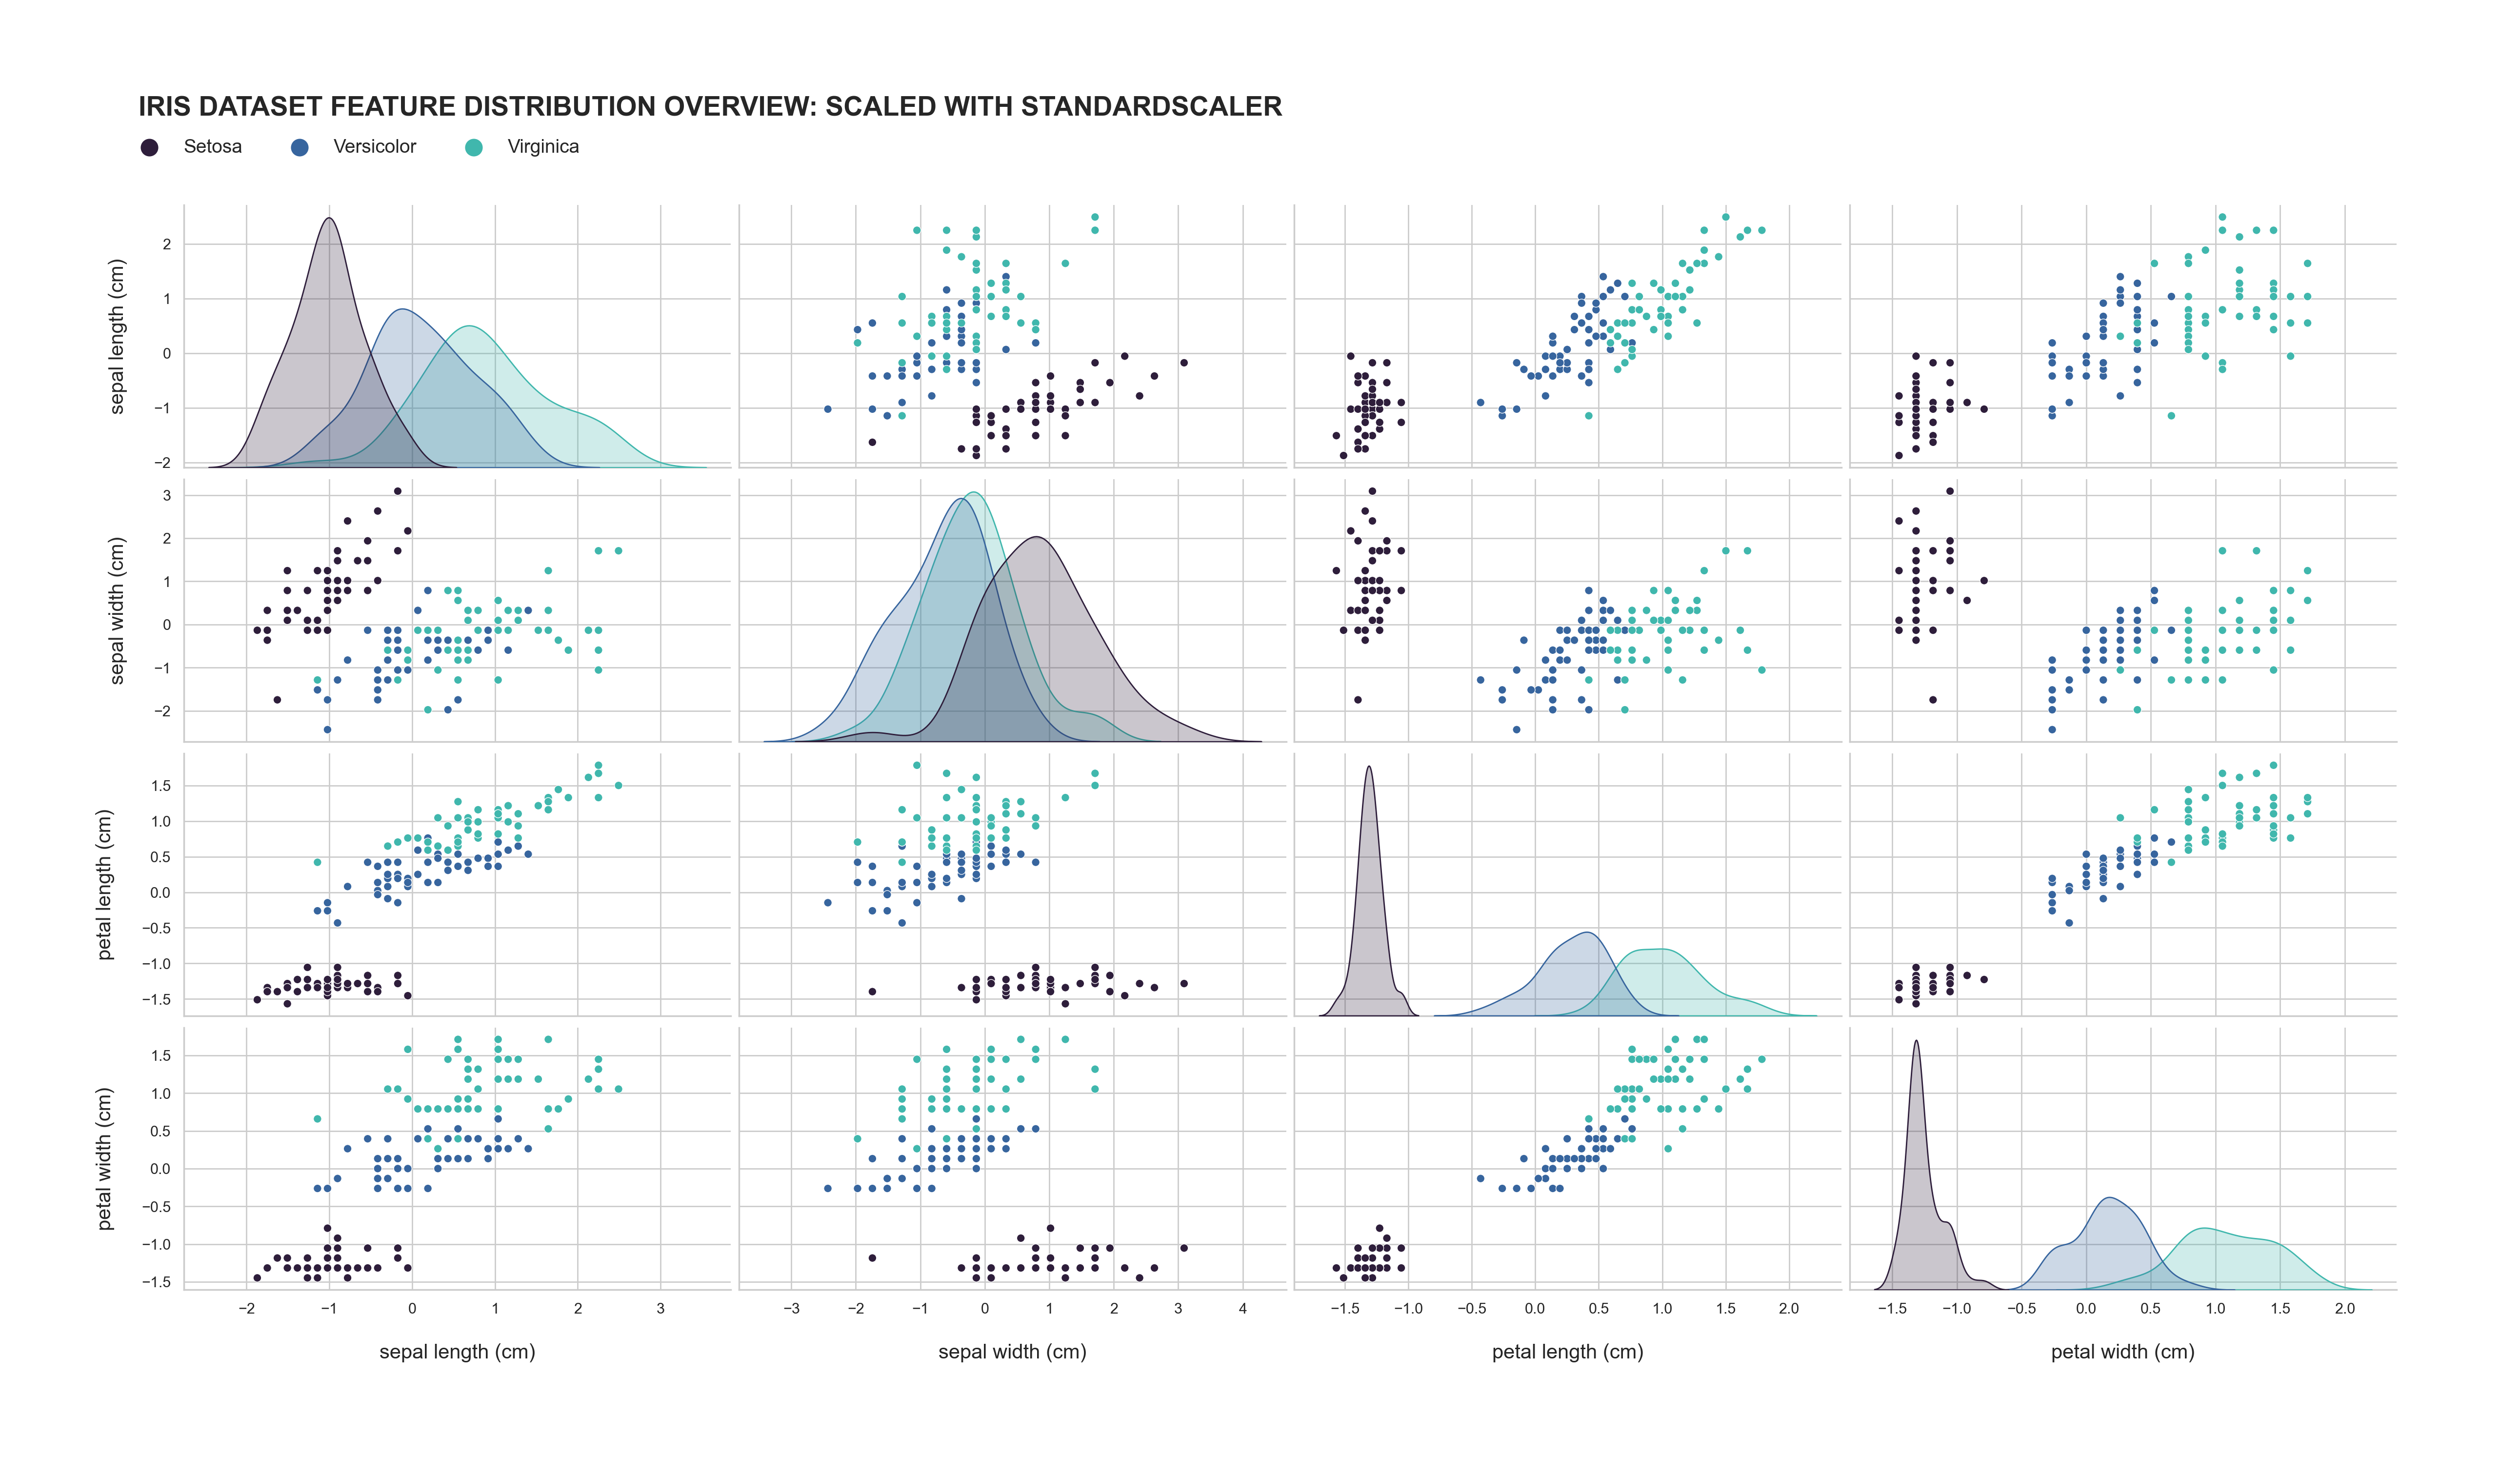

In [138]:
plot_pairplot(
    data = (
        pd.DataFrame(
            columns = data_raw_iris['feature_names'], 
            data = StandardScaler().fit_transform(var_X),)
        .assign(ground_truth_cluster = data_raw_iris['target'])),
    hue = 'ground_truth_cluster',
    title = 'Iris Dataset Feature Distribution Overview: Scaled with StandardScaler',
    labels = [label.title() for label in var_ground_truth_clusters_value_names.values()]
);

#### Making a pipeline with the steps of scaling it first using standard scaler and applying PCA afterwards

In [139]:
pipe_pca = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('method', PCA(n_components = 2, random_state = 0))
])

method_pca = pipe_pca.fit(var_X)

#### Transforming the variable X to two-dimensional with PCA and saving it into a dataframe

In [140]:
df_iris_pca_transformed = (
    pd.DataFrame(
        data = method_pca.transform(var_X),
        columns = ['pc1', 'pc2'],)
    .assign(ground_truth_cluster = var_y_raw))

df_iris_pca_transformed

pc1       pc2  ground_truth_cluster
0   -2.264703  0.480027                     0
1   -2.080961 -0.674134                     0
2   -2.364229 -0.341908                     0
3   -2.299384 -0.597395                     0
4   -2.389842  0.646835                     0
..        ...       ...                   ...
145  1.870503  0.386966                     2
146  1.564580 -0.896687                     2
147  1.521170  0.269069                     2
148  1.372788  1.011254                     2
149  0.960656 -0.024332                     2

[150 rows x 3 columns]

In [141]:
var_X_pca_transformed = df_iris_pca_transformed.iloc[:, [0,1]]

#### Getting the PCA explained variance

In [142]:
var_pca_explainedvariance = method_pca.steps[1][1].explained_variance_ratio_
var_pca_explainedvariance

array([0.72962445, 0.22850762])

#### Visualizing the 2D projection of the dataset

In [143]:
def plot_scatterplot(
    data, x: str, y: str, 
    hue: str, title: str = None, subtitle: str = None,
    x_label: str = None, y_label: str = None,
    labels: list[str] = None, 
    palette: Union[sns.color_palette, str] = sns.color_palette(palette = palette_a1)[::2],
) -> sns.scatterplot:

    title = ' ' if title is None else title
    subtitle = ' ' if subtitle is None else subtitle
    x_label = ' ' if x_label is None else x_label
    y_label = ' ' if y_label is None else y_label
    labels = [] if labels is None else labels

    sns.set(
        style = 'whitegrid',
        rc = {'figure.figsize': (15,4)})

    g = sns.scatterplot(
        data = data, x = x, y = y,
        hue = hue, palette = palette,)

    g.set_xlabel("".join([('\n'*1), (x_label), ('\n'*3)]))
    g.set_ylabel("".join([('\n'*3), (y_label), ('\n'*1)]))

    g.set_title(
        label = "".join([('\n'*3), (title), ('\n'*1)]).upper(), loc = 'left',
        fontdict = dict(fontsize = 14, fontweight = 'bold'),
        y = 1.08, )

    sns.move_legend(
        obj = g, loc = 'lower right', ncol = 3,
        title = None, frameon = False, bbox_to_anchor = (1, 1.025),
        handles = g.legend_.legendHandles, labels = labels,)

    plt.text(
        s = f'{subtitle}', x = 0, y = 1.08,
        alpha = 0.5, horizontalalignment = 'left',
        transform = g.axes.transAxes,
        fontdict = dict(fontsize = 11),)

    plt.text(
        s = ' ', x = 1.1, y = 1,
        transform = g.axes.transAxes,)

    sns.despine()

    return g

/home/cabrera/anaconda3/envs/dsa/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


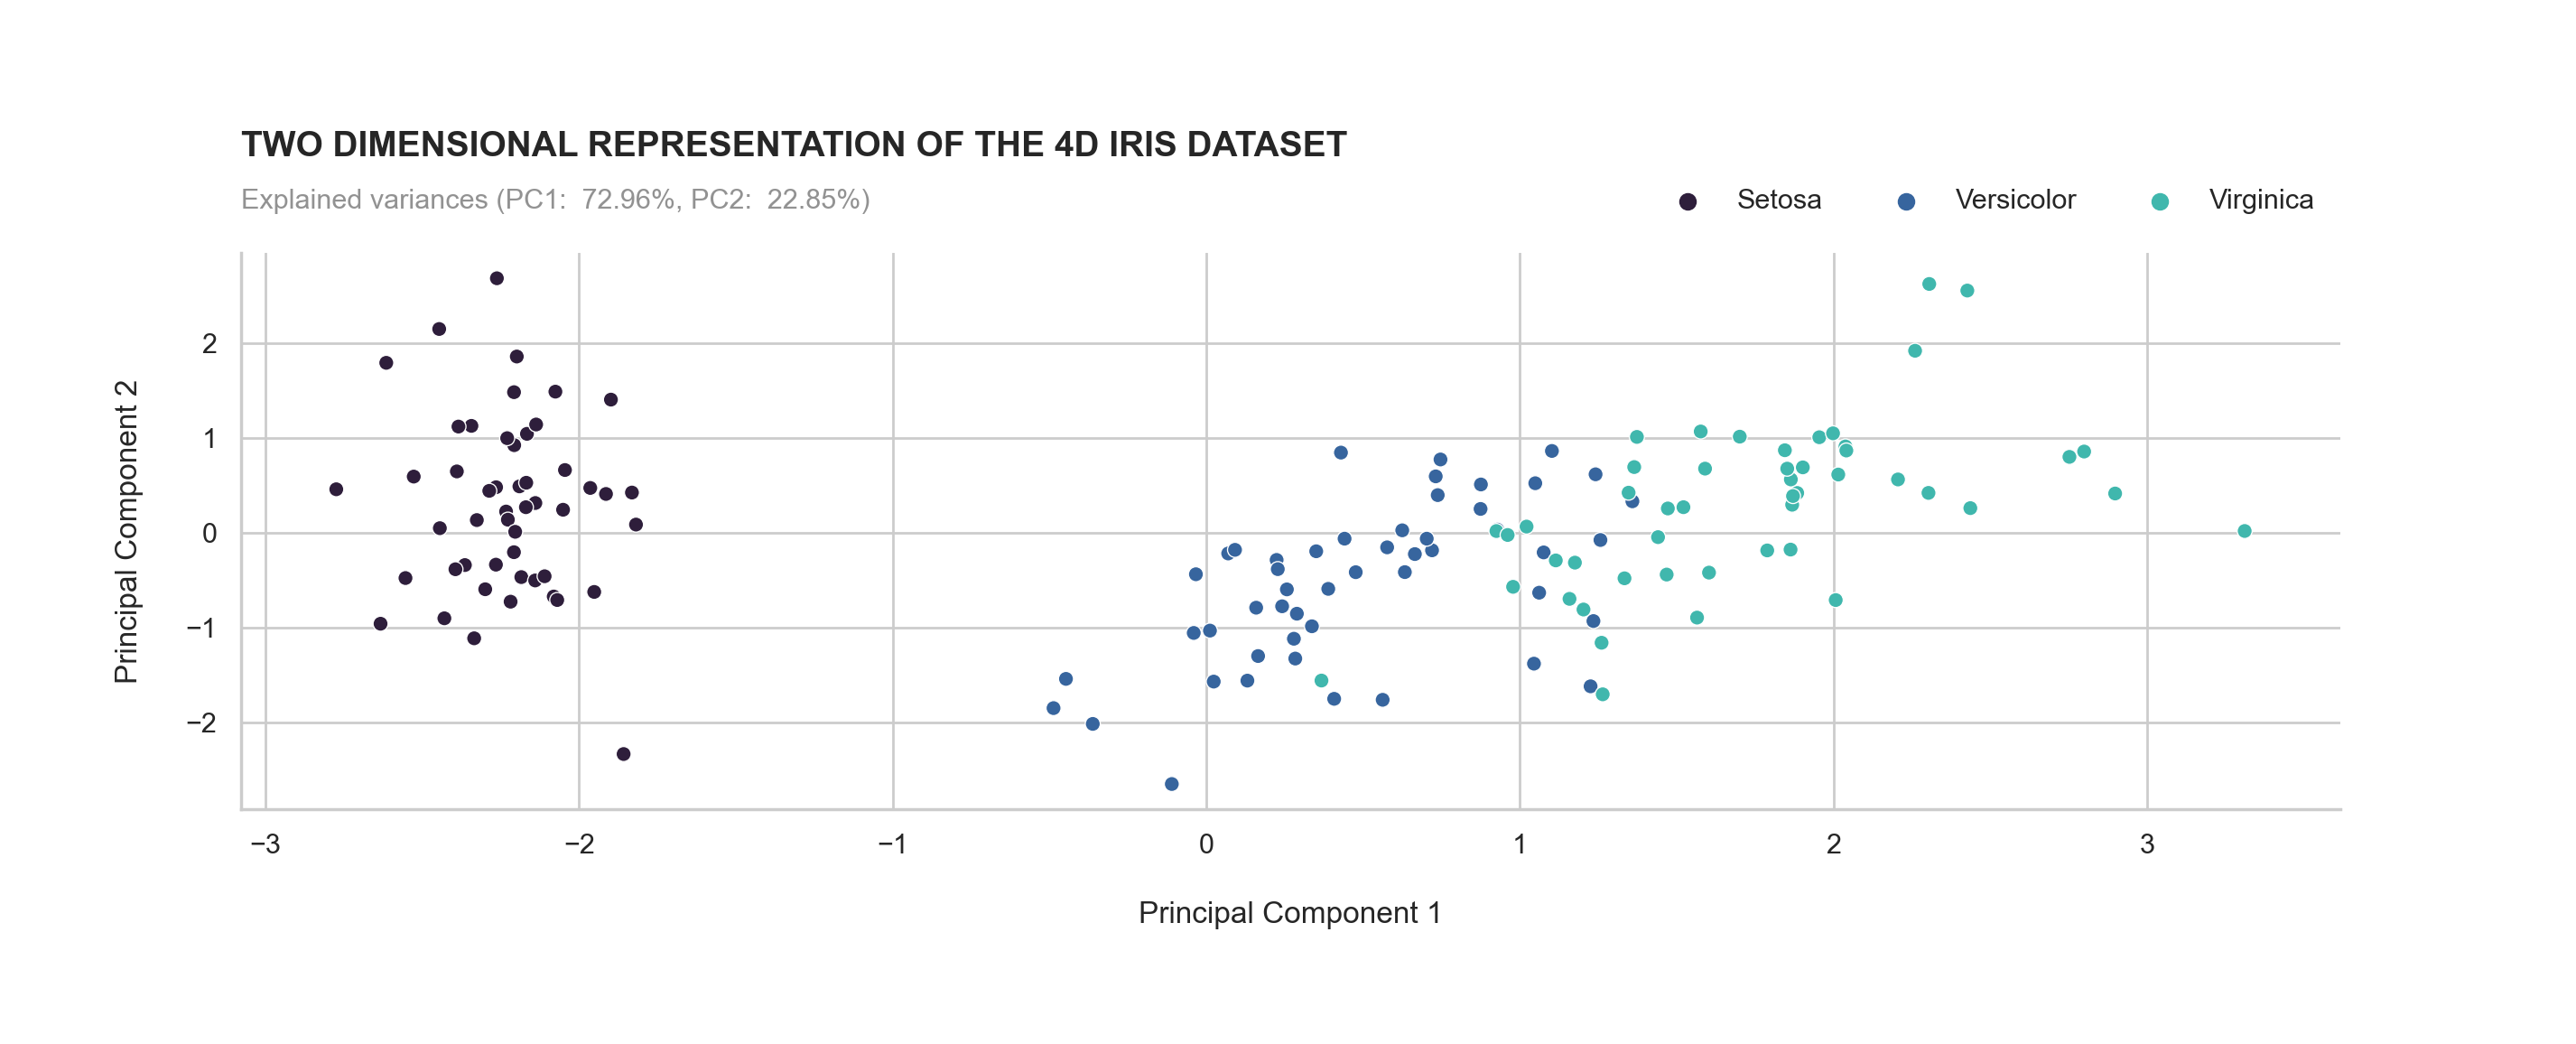

In [144]:
plot_scatterplot(
    data = df_iris_pca_transformed, x = 'pc1', y = 'pc2',
    x_label = "Principal Component 1", y_label = "Principal Component 2",
    hue = 'ground_truth_cluster', title = 'Two dimensional representation of the 4D Iris Dataset',
    subtitle = f"Explained variances (PC1: {var_pca_explainedvariance[0]: 1.2%}, PC2: {var_pca_explainedvariance[1]: 1.2%})",
    labels = [label.title() for label in var_ground_truth_clusters_value_names.values()]
);

With the explained variance of principal component 1 being 72.96% and that of the principal component 2 being 22.85%, together, these two components makes up for 95.81% of the information. That's four dimensional data compressed into two dimension.

## K-means clustering

In [145]:
model_kmeans = KMeans()

### Implementing elbow method and visualizing the elbow plot to determine the optimal value of k

Getting the list of sum squared distances of samples to their closest cluster centers

In [146]:
def elbow_getinertia(X, kmeans_model: KMeans) -> list[float]:
    return [kmeans_model.set_params(**{'n_clusters': x}).fit(X).inertia_ for x in range(1,11)]

In [147]:
def plot_lineplot(
    x, y, data = None, 
    color: Union[sns.color_palette, str] = None,
    title: str = None, x_label: str = None, y_label: str = None
) -> sns.lineplot:

    data = None if data is None else data
    color = color_a1 if color is None else color
    title = ' ' if title is None else title
    x_label = ' ' if x_label is None else x_label
    y_label = ' ' if y_label is None else y_label

    sns.set(style = 'whitegrid', rc = {'figure.figsize': (14,4)})

    g = sns.lineplot(
        data = data, x = x, y = y,
        color = color, marker = 'o', dashes = False,)

    g.set_title(
        label = "".join([('\n'*3), (title), ('\n'*1)]).upper(), loc = 'left',
        fontdict = dict(fontsize = 13, fontweight = 'bold'),)

    g.set_xlabel(
        xlabel = "".join([('\n'*1), (x_label), ('\n'*3)]), 
        fontdict = dict(fontsize = 12, fontweight = 'medium'),)

    g.set_ylabel(
        ylabel = "".join([('\n'*3), (y_label), ('\n'*1)]), 
        fontdict = dict(fontsize = 12, fontweight = 'medium'),)

    plt.text(
        s = ' ', x = 1.1, y = 0,
        transform = g.axes.transAxes, )

    sns.despine()

    return g

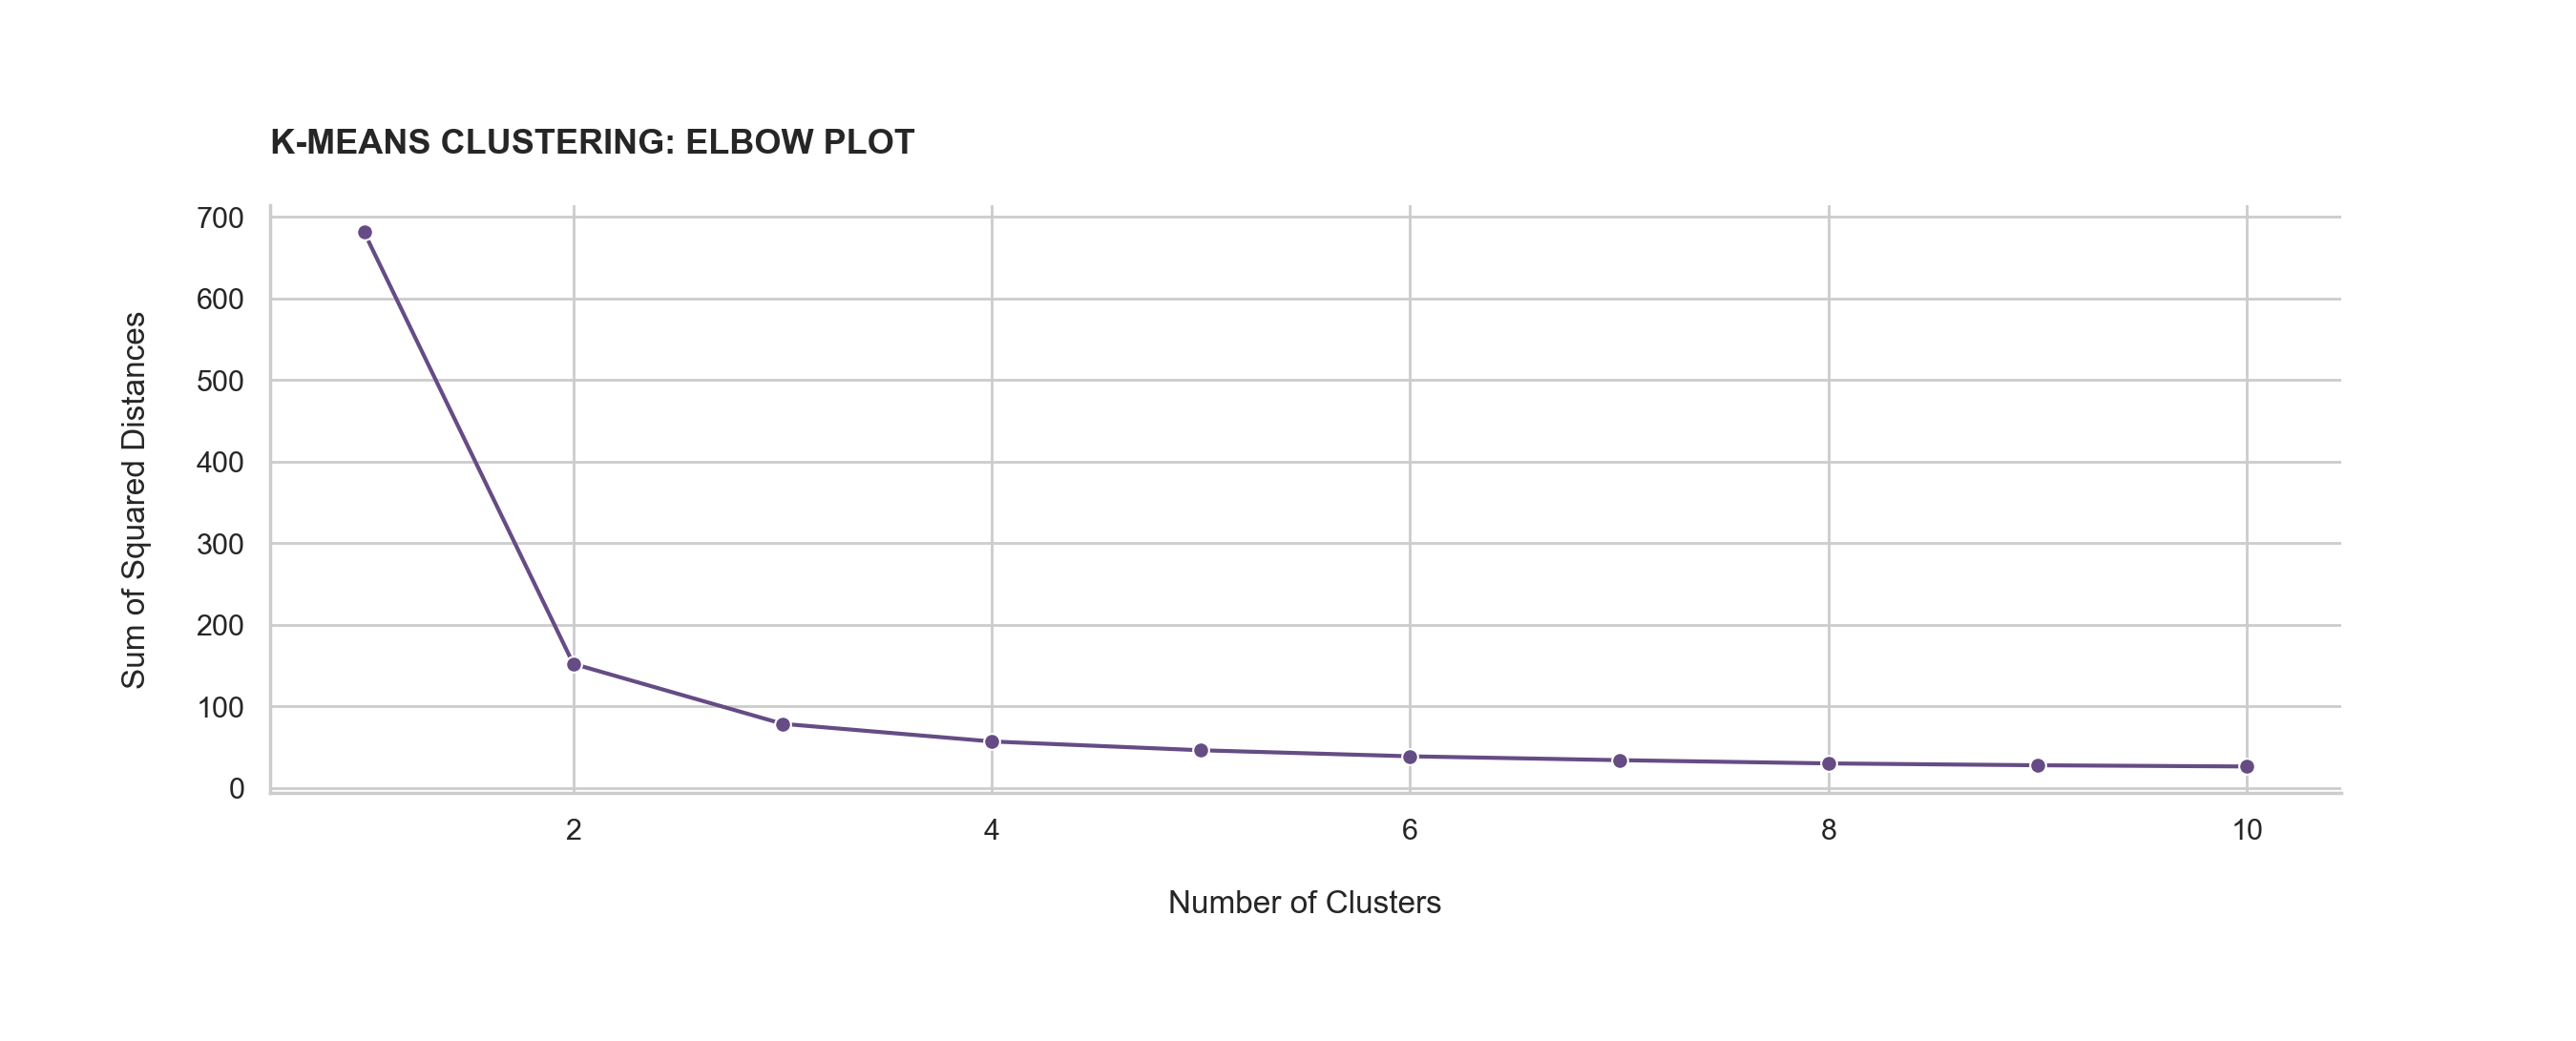

In [148]:
plot_lineplot(
    x = range(1,11), y = elbow_getinertia(X = var_X, kmeans_model = model_kmeans),
    title = 'K-means Clustering: Elbow plot',
    x_label = 'Number of Clusters', y_label = 'Sum of Squared Distances'
);

There is a huge reduction in inertia or the sum of squared distances at k = 2, but after that the inertia doesn't go down as quickly. Thus, this is the elbow in the plot and, hence, I will choose k = 3

### Training the model with a k value of 3

In [149]:
# Set the k value to 3
model_kmeans.set_params(**{'n_clusters': 3})

# Train the model
model_kmeans.fit(var_X_pca_transformed)

KMeans(n_clusters=3)

#### Current model parameter

In [150]:
model_kmeans.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 3,
 'n_init': 10,
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

### Visualization

As visualizing 4 dimensions of data can be a bit hard to consume, I will be using the two principal components that I used previously in Principal Component Analysis (PCA)

In [151]:
df_iris_pca_transformed_kmeans = df_iris_pca_transformed.assign(predicted_cluster = model_kmeans.predict(var_X_pca_transformed))
df_iris_pca_transformed_kmeans

pc1       pc2  ground_truth_cluster  predicted_cluster
0   -2.264703  0.480027                     0                  1
1   -2.080961 -0.674134                     0                  1
2   -2.364229 -0.341908                     0                  1
3   -2.299384 -0.597395                     0                  1
4   -2.389842  0.646835                     0                  1
..        ...       ...                   ...                ...
145  1.870503  0.386966                     2                  2
146  1.564580 -0.896687                     2                  0
147  1.521170  0.269069                     2                  2
148  1.372788  1.011254                     2                  2
149  0.960656 -0.024332                     2                  0

[150 rows x 4 columns]

#### K-means clustered

/home/cabrera/anaconda3/envs/dsa/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


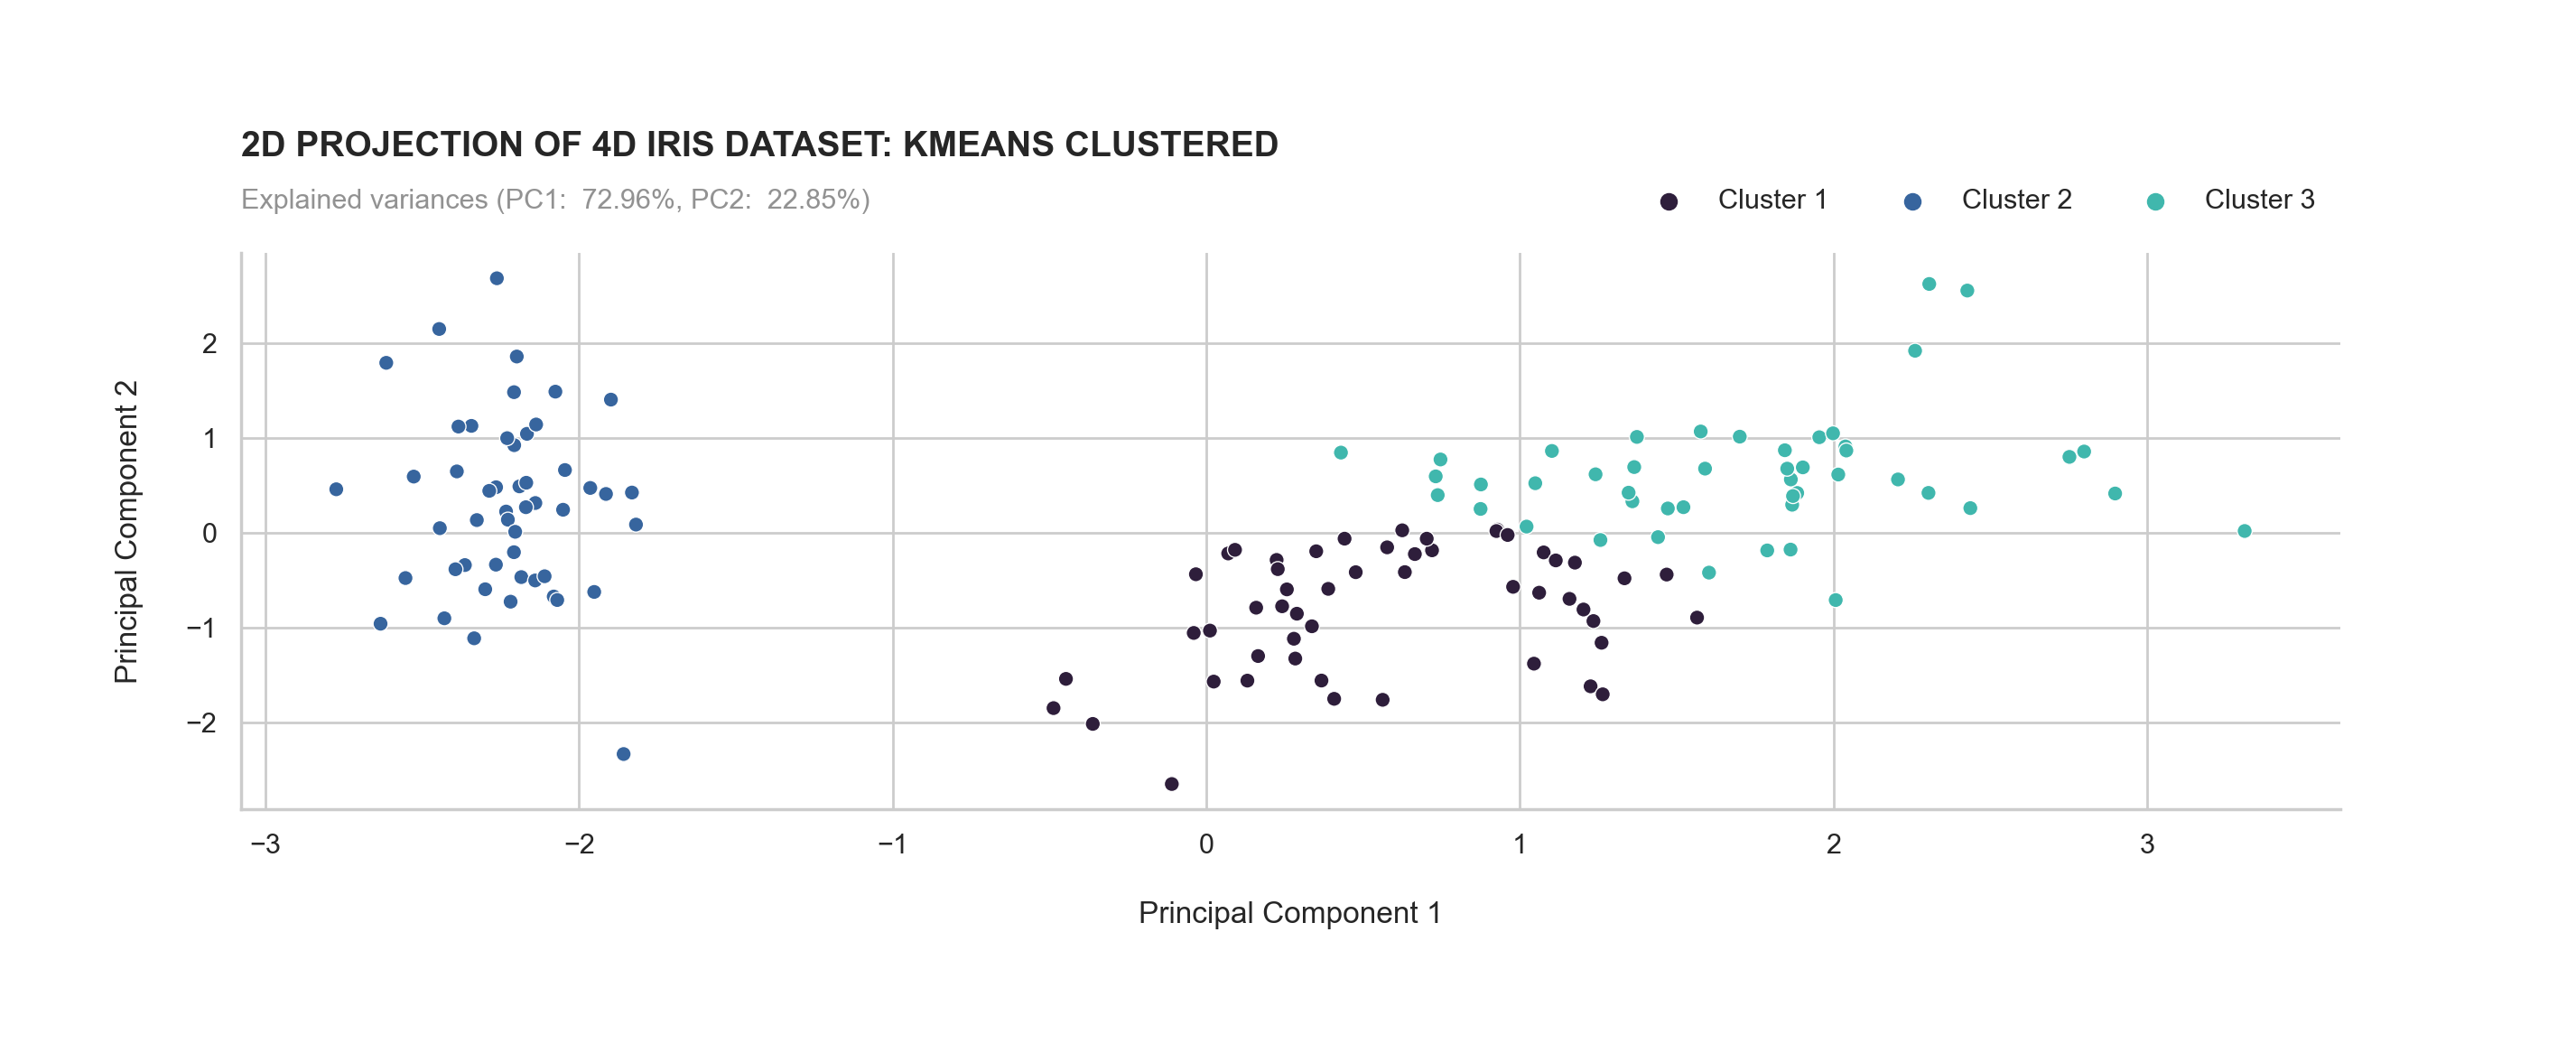

In [152]:
plot_scatterplot(
    data = df_iris_pca_transformed_kmeans, x = 'pc1', y = 'pc2',
    hue = 'predicted_cluster', x_label = "Principal Component 1", y_label = "Principal Component 2",
    title = '2D projection of 4D Iris Dataset: Kmeans Clustered', labels = ['Cluster 1', 'Cluster 2', 'Cluster 3'],
    subtitle = f"Explained variances (PC1: {var_pca_explainedvariance[0]: 1.2%}, PC2: {var_pca_explainedvariance[1]: 1.2%})",
);

#### Ground truth clusters

/home/cabrera/anaconda3/envs/dsa/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


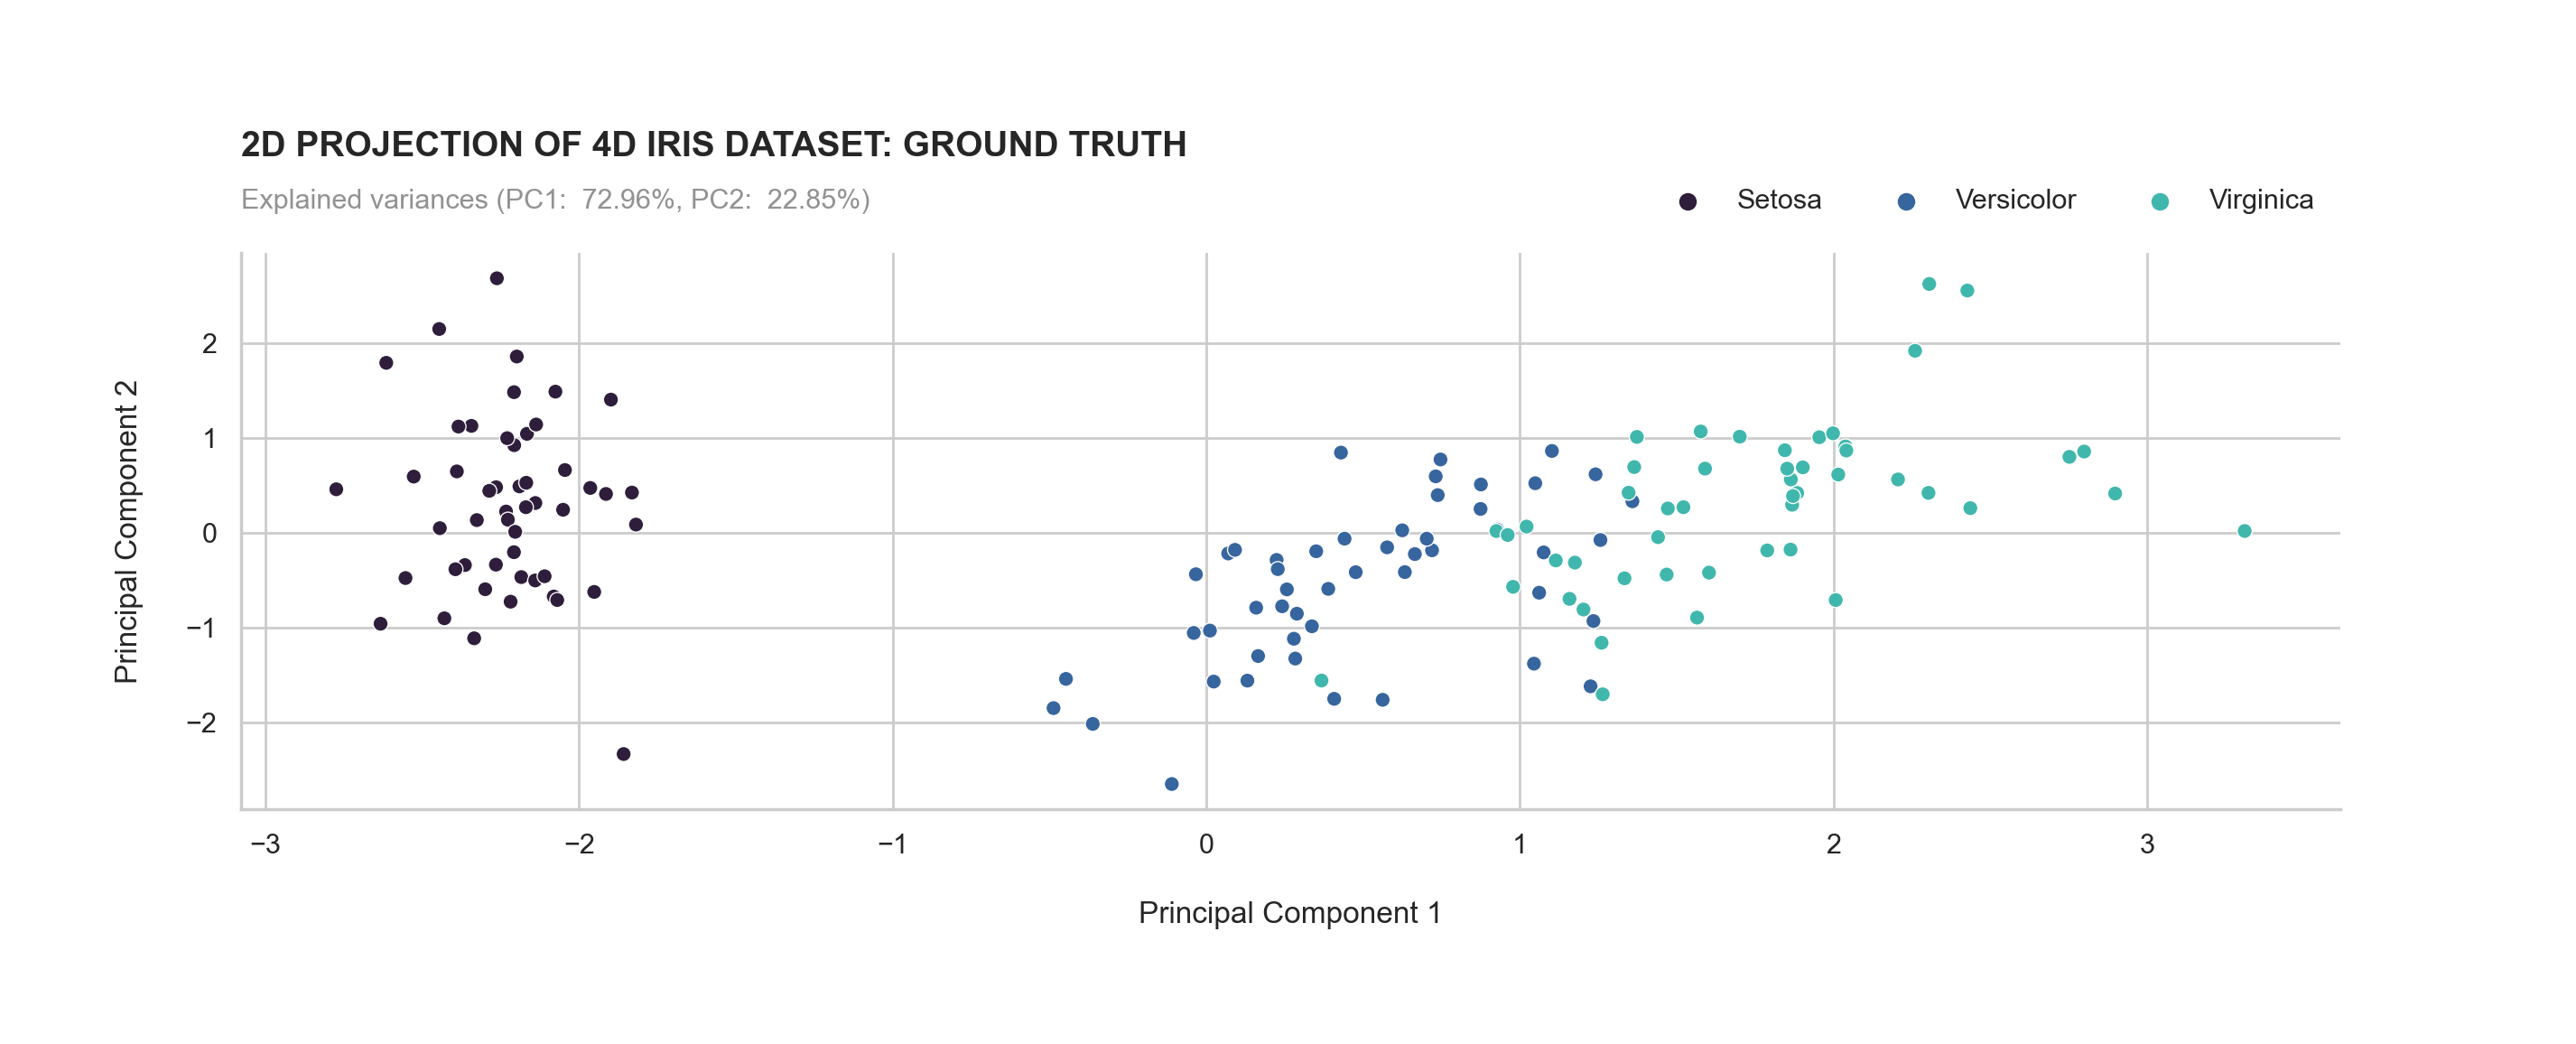

In [153]:
plot_scatterplot(
    data = df_iris_pca_transformed, x = 'pc1', y = 'pc2',
    hue = 'ground_truth_cluster', x_label = "Principal Component 1", y_label = "Principal Component 2",
    title = '2D projection of 4D Iris Dataset: Ground Truth', labels = [x.title() for x in var_ground_truth_clusters_value_names.values()],
    subtitle = f"Explained variances (PC1: {var_pca_explainedvariance[0]: 1.2%}, PC2: {var_pca_explainedvariance[1]: 1.2%})",
);

### Evaluating the result using clustering metrics: Adjusted Rand Index (ARI) and Silhouette Score

Adjusted Rand Index (ARI) assess the outcome of the clustering results relative to the ground truth clustering. Silhouette score on the other hand, computes the compactness of a cluster where the higher is better with 1 as the perfect score and it does not require ground truth.

In [154]:
def evaluate_clustering_result(ari_labels_true, ari_labels_pred, X) -> dict:
    ari = adjusted_rand_score(labels_true = ari_labels_true, labels_pred = ari_labels_pred)
    silhouette = silhouette_score(X = X, labels = ari_labels_pred)

    return dict(adjusted_rand_score = ari, silhouette_score = silhouette)

In [155]:
def plot_barplot(
    x, y, data = None, figsize: tuple = None,
    palette = None, x_label: str = None, y_label: str = None,
    title: str = None, x_lim:tuple = None
) -> sns.barplot:

    figsize = (13,5) if figsize is None else figsize
    data = None if data is None else data
    title = ' ' if title is None else title
    x_label = ' ' if x_label is None else x_label
    y_label = ' ' if y_label is None else y_label
    x_lim is None if x_lim is None else x_lim
    palette = palette_a1 if palette is None else palette

    sns.set(style = 'whitegrid', rc = {'figure.figsize': figsize})

    g = sns.barplot(
        data = data, x = x, y = y,
        palette = palette, )

    g.bar_label(container = g.containers[0], padding = 10, fmt = '%.3f')

    g.set_xlabel("".join([(' '), ('\n'*1), (f'{x_label}'), ('\n'*3)]))
    g.set_ylabel("".join([(' '), ('\n'*3), (f'{y_label}'), ('\n'*1)]))

    g.set_title(
        label = "".join([(' '), ('\n'*3), (f'{title}'), ('\n'*1)]).upper(),
        loc = 'left', fontdict = dict(fontsize = 13, fontweight = 'bold'), )

    g.set_xlim(x_lim)

    plt.text(
        s = ' ', x = 1.15, y = 1,
        transform = g.axes.transAxes)

    sns.despine()

#### Metrics score visualization

In [156]:
var_clustering_evaluation_kmeans = evaluate_clustering_result(
    X = var_X_pca_transformed,
    ari_labels_true = df_iris_pca_transformed_kmeans['ground_truth_cluster'],
    ari_labels_pred = df_iris_pca_transformed_kmeans['predicted_cluster'], )

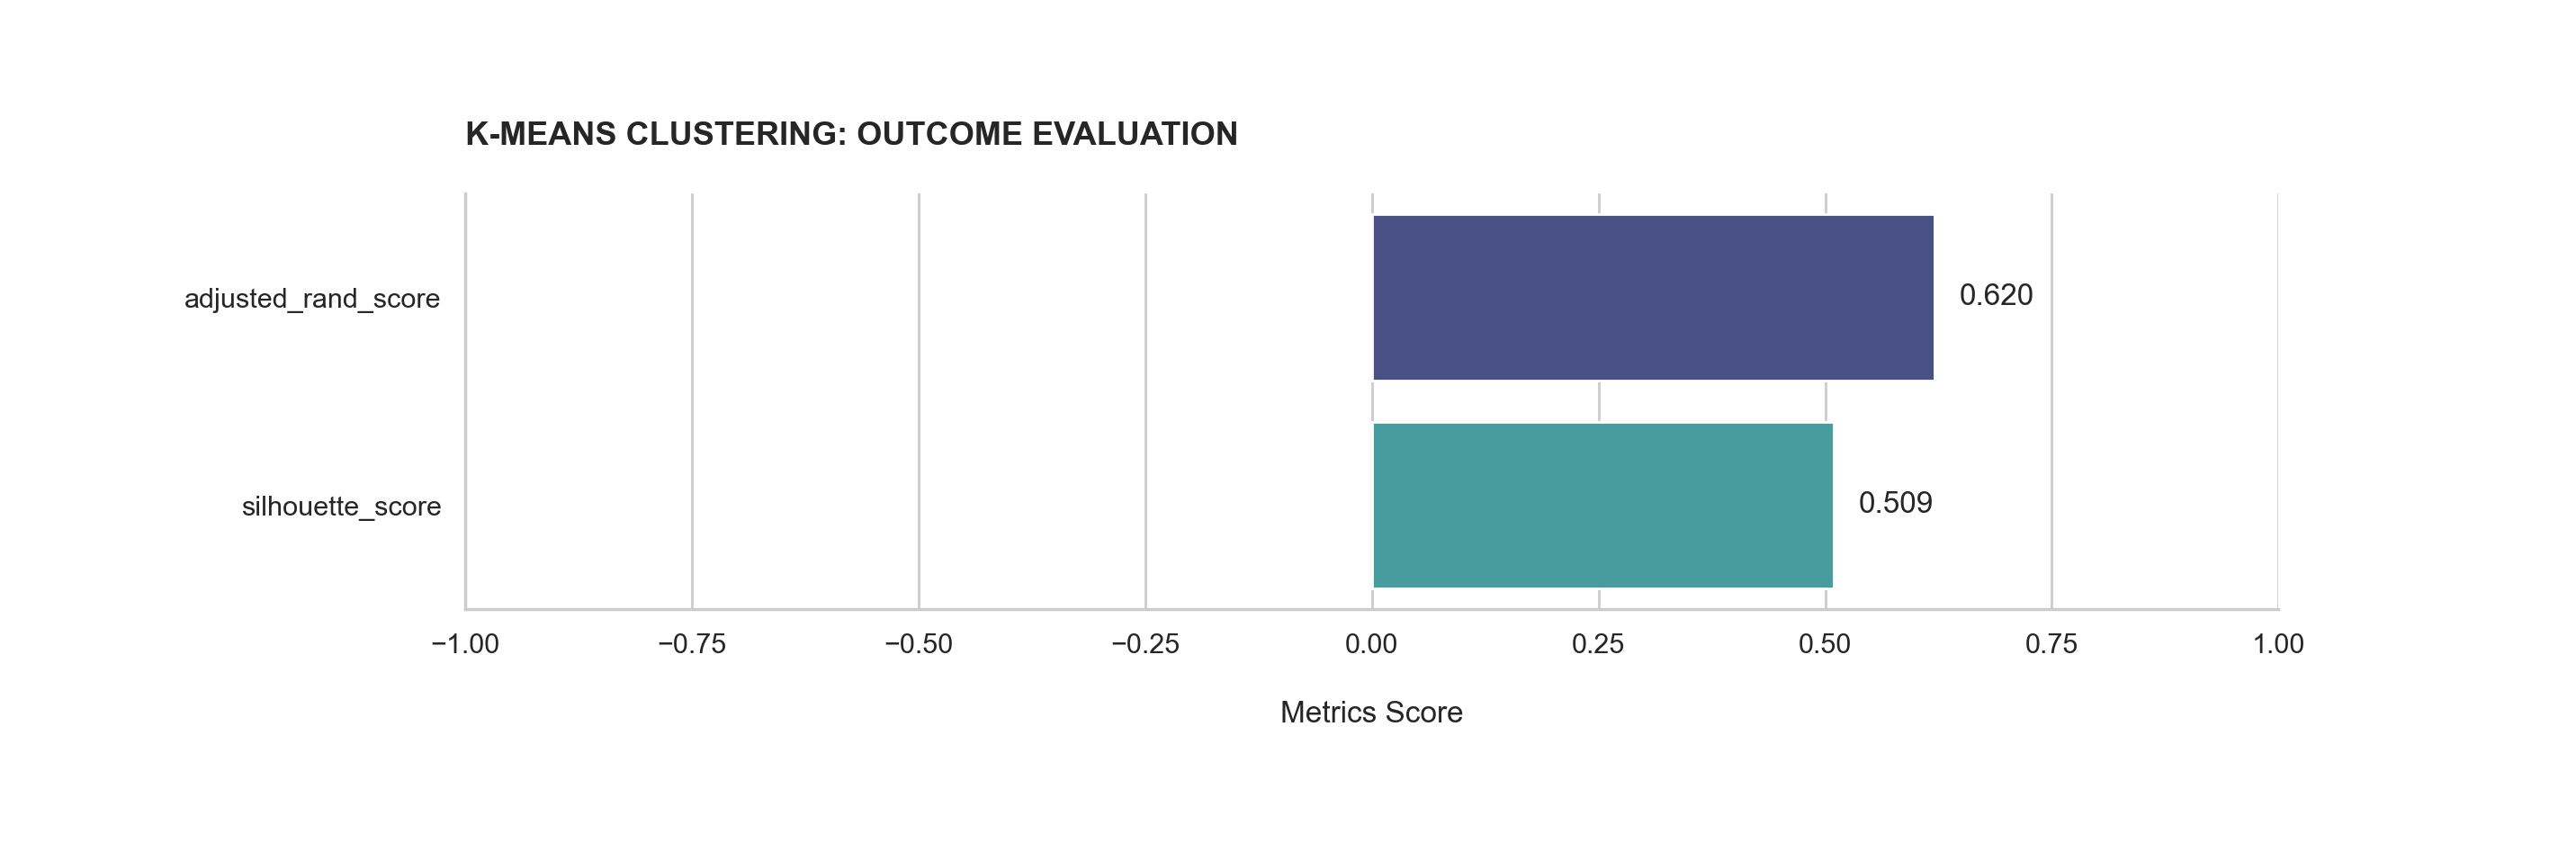

In [157]:
plot_barplot(
    data = (
        pd.DataFrame(
            index = var_clustering_evaluation_kmeans.keys(),
            data = var_clustering_evaluation_kmeans.values())
        .reset_index()
        .rename(columns = {'index' : 'metrics', 0 : 'score'})),
    x = 'score', y = 'metrics', figsize = (13, 3),
    x_label = 'Metrics Score', x_lim = (-1, 1),
    title = "K-means Clustering: Outcome Evaluation"
)

## Density-based spatial clustering of applications with noise (DBSCAN)

In [158]:
model_dbscan = DBSCAN()

### Training the model

In [159]:
model_dbscan.fit(var_X_pca_transformed)

DBSCAN()

#### Current model parameters

In [160]:
model_dbscan.get_params()

{'algorithm': 'auto',
 'eps': 0.5,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 5,
 'n_jobs': None,
 'p': None}

### Visualization

Making a dataframe and assigning the predicted clusters to predicted_cluster column

In [161]:
df_iris_pca_transformed_dbscan = df_iris_pca_transformed.assign(predicted_cluster = model_dbscan.fit_predict(var_X_pca_transformed))
df_iris_pca_transformed_dbscan

pc1       pc2  ground_truth_cluster  predicted_cluster
0   -2.264703  0.480027                     0                  0
1   -2.080961 -0.674134                     0                  0
2   -2.364229 -0.341908                     0                  0
3   -2.299384 -0.597395                     0                  0
4   -2.389842  0.646835                     0                  0
..        ...       ...                   ...                ...
145  1.870503  0.386966                     2                  1
146  1.564580 -0.896687                     2                  1
147  1.521170  0.269069                     2                  1
148  1.372788  1.011254                     2                  1
149  0.960656 -0.024332                     2                  1

[150 rows x 4 columns]

The fit_predict method of dbscan returns the cluster labels with noisy samples / outliers given the label -1

In [162]:
df_iris_pca_transformed_dbscan['predicted_cluster'].value_counts()

 1    90
 0    48
-1    12
Name: predicted_cluster, dtype: int64

#### DBSCAN clustered

/home/cabrera/anaconda3/envs/dsa/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


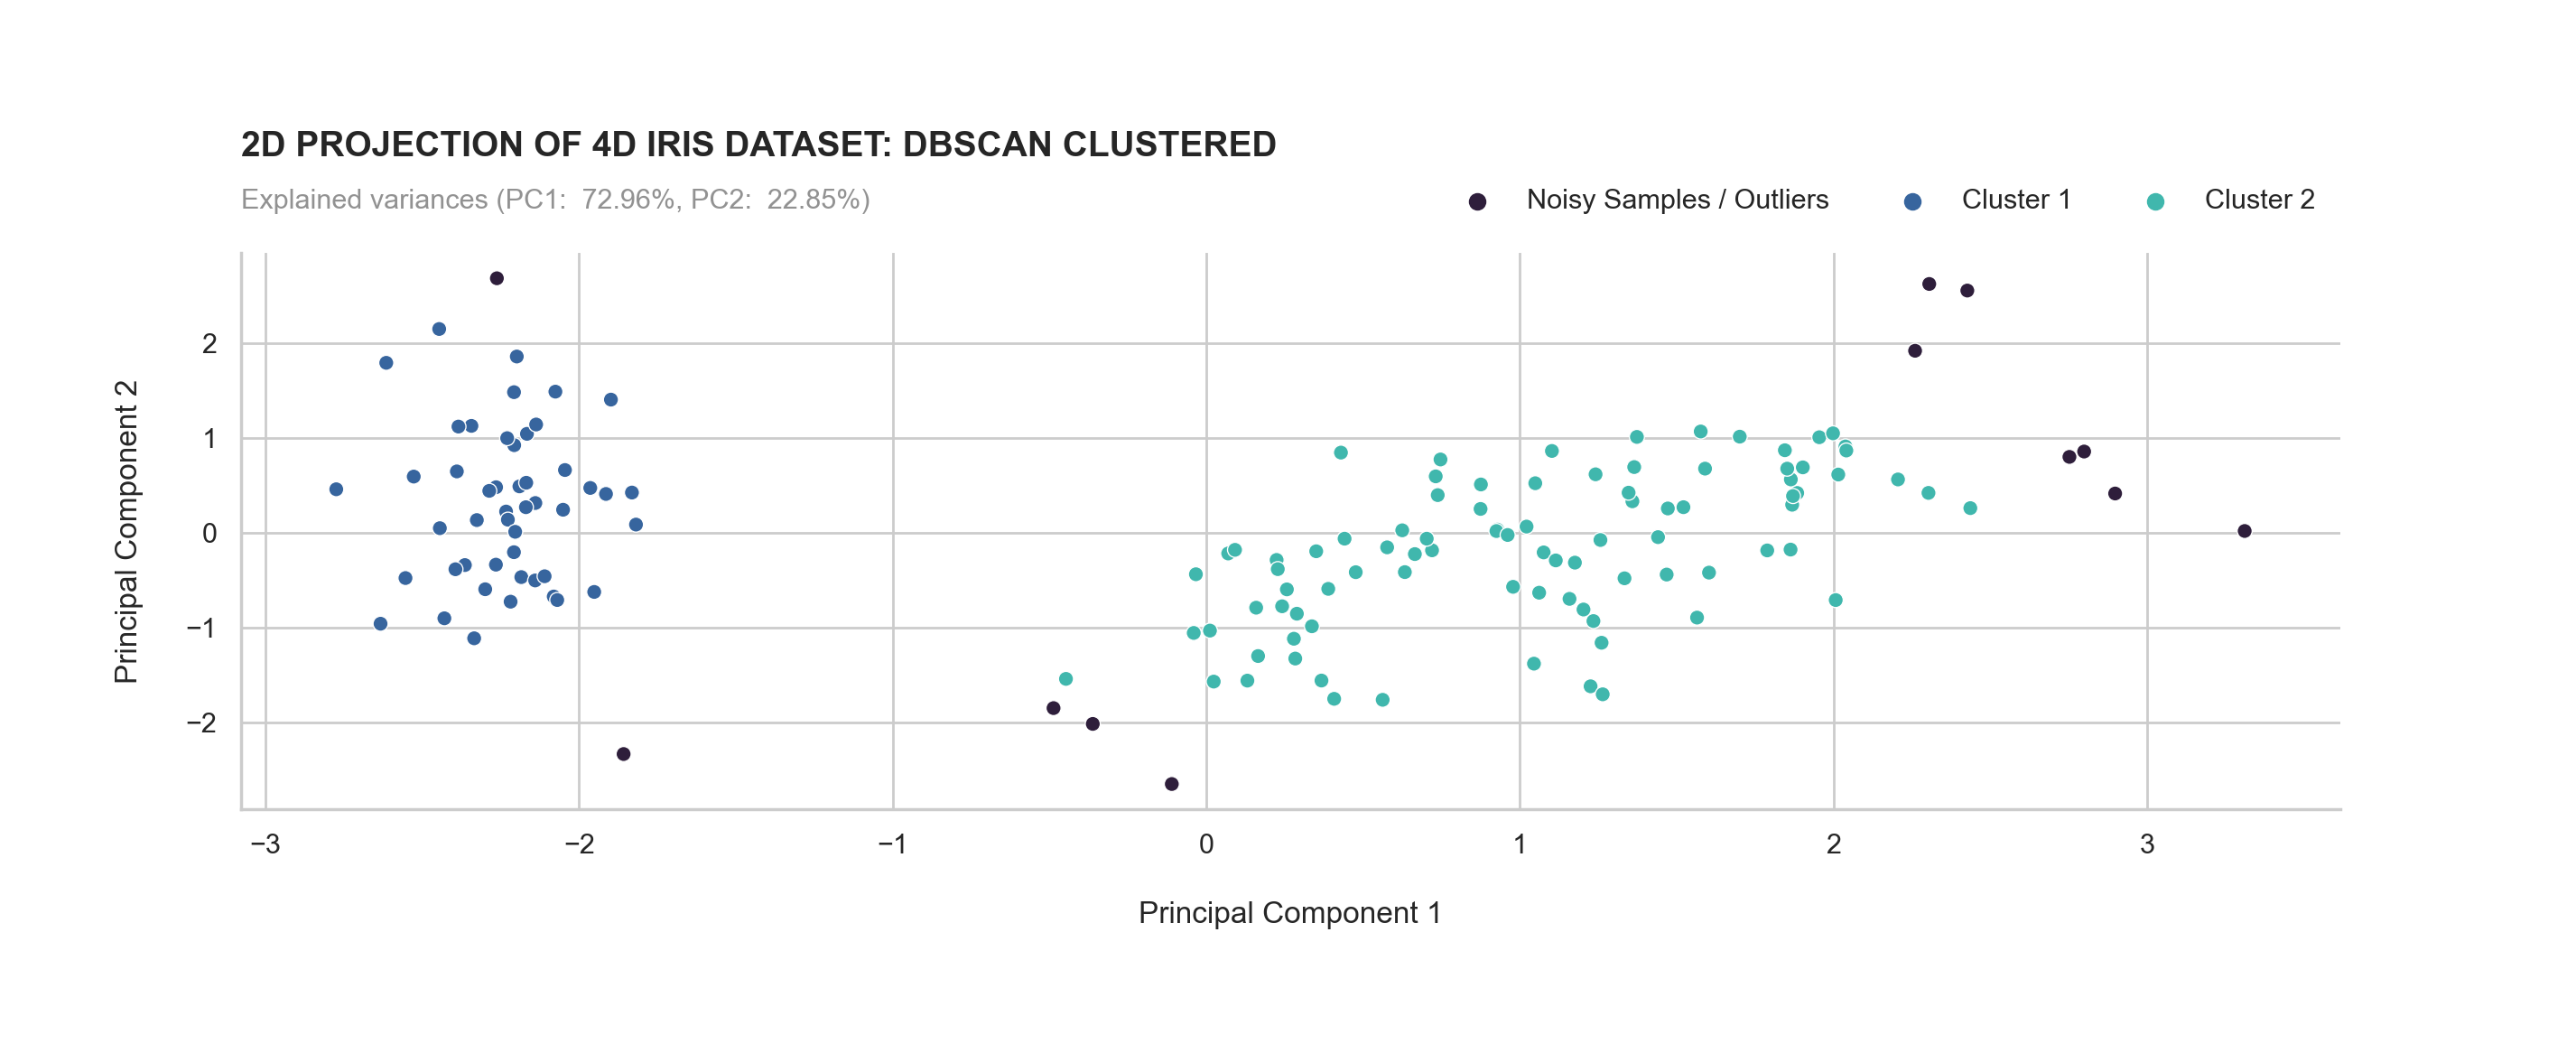

In [163]:
plot_scatterplot(
    data = df_iris_pca_transformed_dbscan, x = 'pc1', y = 'pc2',
    hue = 'predicted_cluster', x_label = "Principal Component 1", y_label = "Principal Component 2",
    title = '2D projection of 4D Iris Dataset: DBSCAN Clustered', labels = ['Noisy Samples / Outliers', 'Cluster 1', 'Cluster 2'],
    subtitle = f"Explained variances (PC1: {var_pca_explainedvariance[0]: 1.2%}, PC2: {var_pca_explainedvariance[1]: 1.2%})",
);

#### Ground truth clusters

/home/cabrera/anaconda3/envs/dsa/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


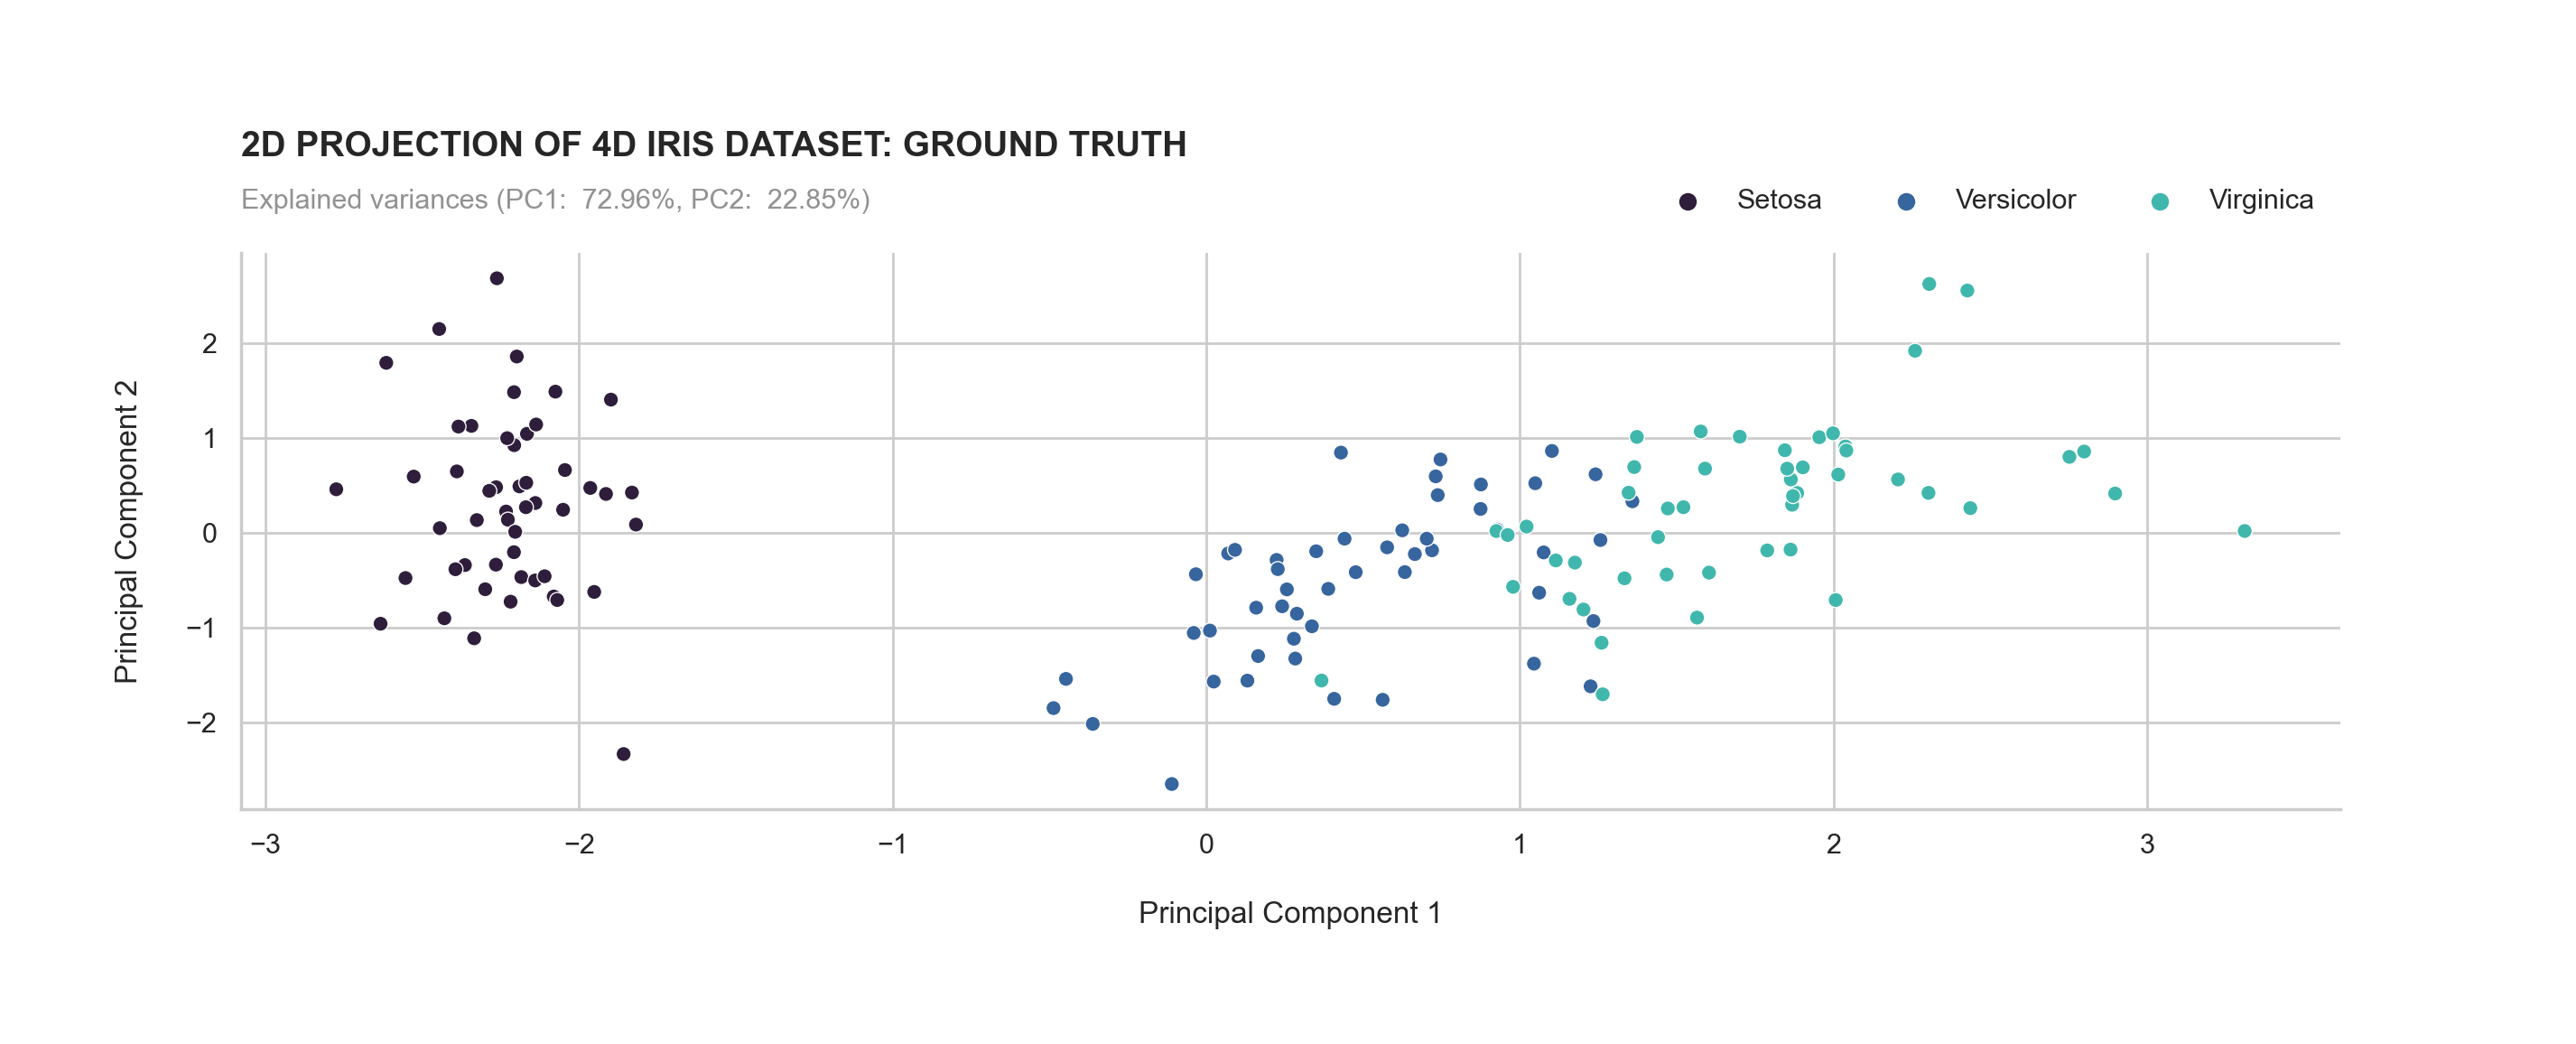

In [164]:
plot_scatterplot(
    data = df_iris_pca_transformed, x = 'pc1', y = 'pc2',
    hue = 'ground_truth_cluster', x_label = "Principal Component 1", y_label = "Principal Component 2",
    title = '2D projection of 4D Iris Dataset: Ground Truth', labels = [x.title() for x in var_ground_truth_clusters_value_names.values()],
    subtitle = f"Explained variances (PC1: {var_pca_explainedvariance[0]: 1.2%}, PC2: {var_pca_explainedvariance[1]: 1.2%})",
);

#### Metrics score visualization

In [165]:
var_clustering_evaluation_dbscan = evaluate_clustering_result(
    X = var_X_pca_transformed,
    ari_labels_true = df_iris_pca_transformed_dbscan['ground_truth_cluster'],
    ari_labels_pred = df_iris_pca_transformed_dbscan['predicted_cluster'], )

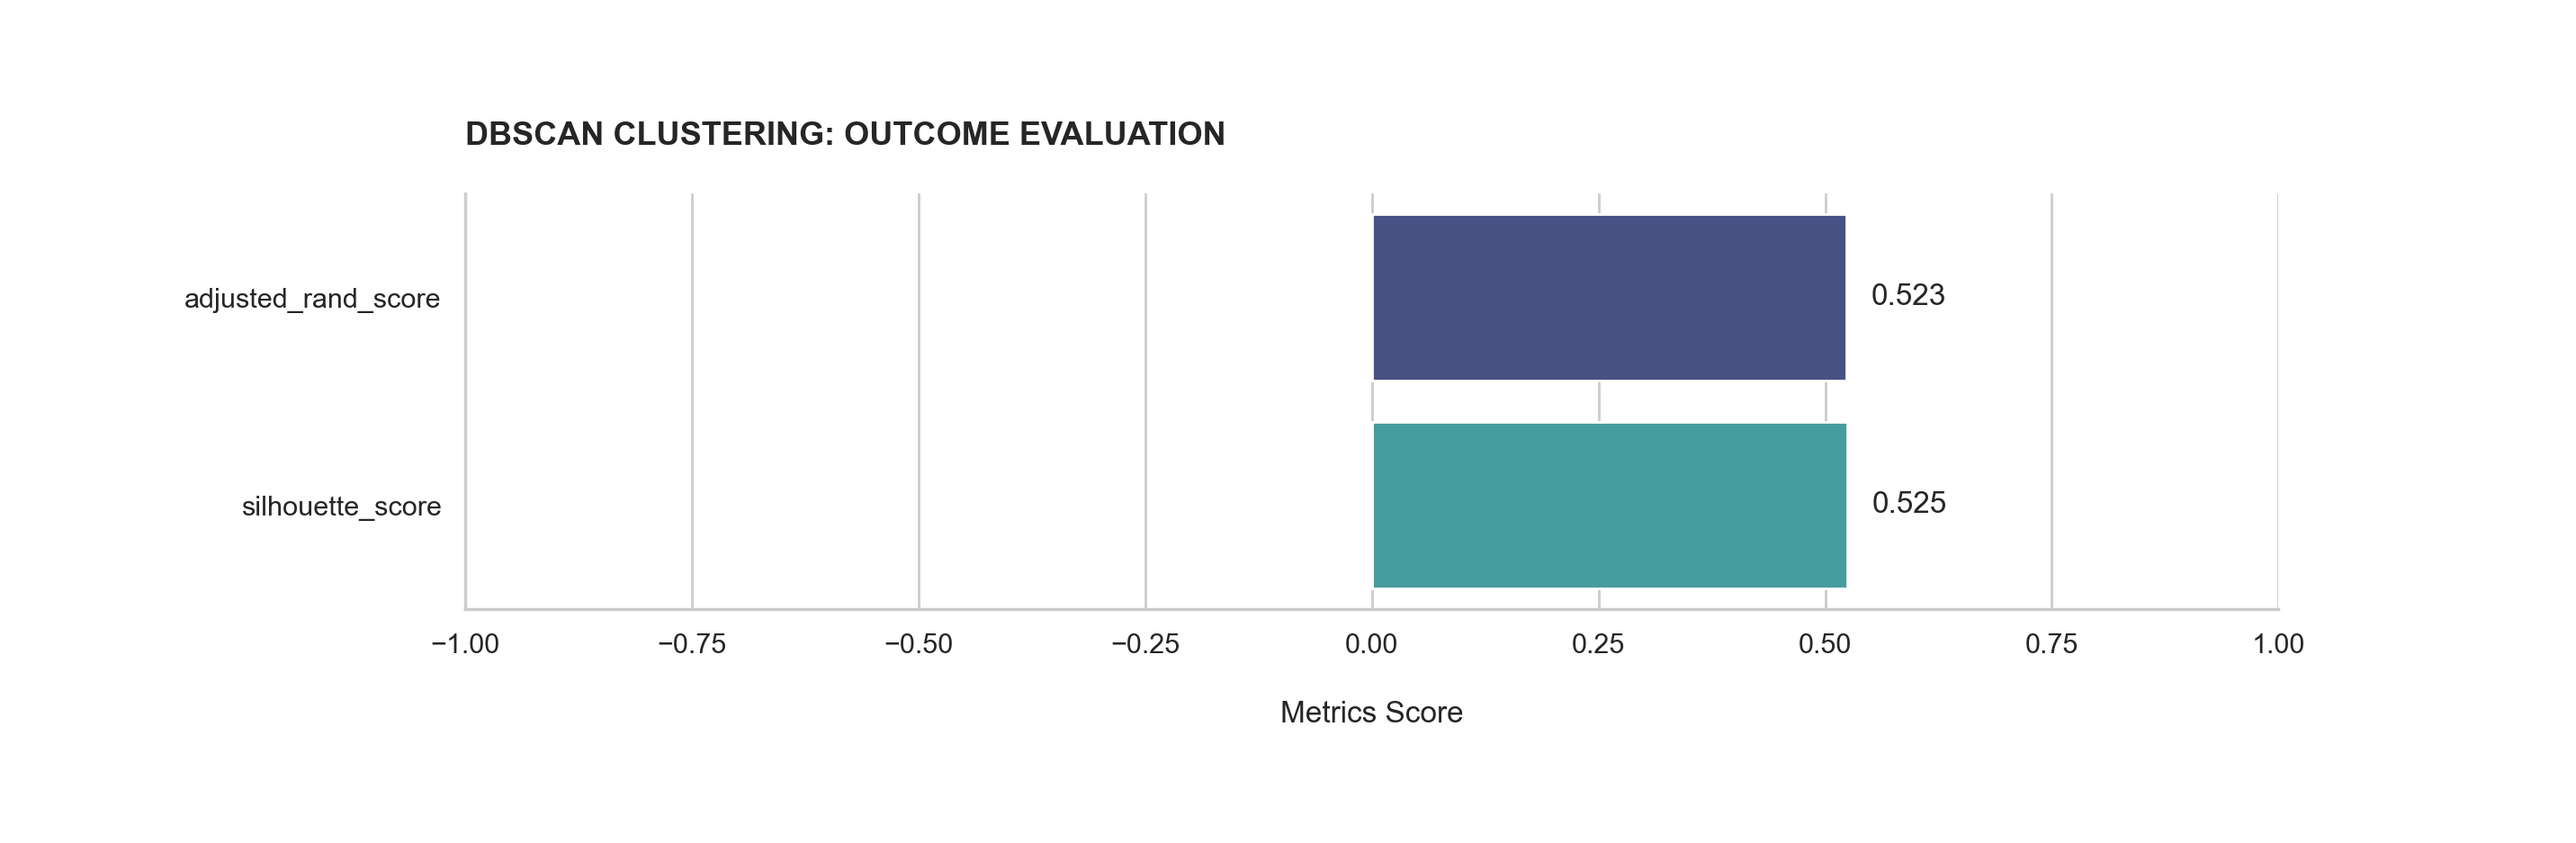

In [166]:
plot_barplot(
    data = (
        pd.DataFrame(
            index = var_clustering_evaluation_dbscan.keys(),
            data = var_clustering_evaluation_dbscan.values())
        .reset_index()
        .rename(columns = {'index' : 'metrics', 0 : 'score'})),
    x = 'score', y = 'metrics', figsize = (13, 3),
    x_label = 'Metrics Score', x_lim = (-1, 1),
    title = "DBSCAN Clustering: Outcome Evaluation"
)

## Hierarchical clustering: Agglomerative clustering

In [167]:
model_agglomerative = AgglomerativeClustering(n_clusters = 3)

### Training the model

In [168]:
model_agglomerative.fit(var_X_pca_transformed)

AgglomerativeClustering(n_clusters=3)

#### Current model parameters

In [169]:
model_agglomerative.get_params()

{'affinity': 'euclidean',
 'compute_distances': False,
 'compute_full_tree': 'auto',
 'connectivity': None,
 'distance_threshold': None,
 'linkage': 'ward',
 'memory': None,
 'n_clusters': 3}

### Visualization

Making a dataframe and assigning the predicted clusters to predicted_cluster column

In [170]:
df_iris_pca_transformed_agglomerative = df_iris_pca_transformed.assign(predicted_cluster = model_agglomerative.fit_predict(var_X_pca_transformed))
df_iris_pca_transformed_agglomerative

pc1       pc2  ground_truth_cluster  predicted_cluster
0   -2.264703  0.480027                     0                  0
1   -2.080961 -0.674134                     0                  0
2   -2.364229 -0.341908                     0                  0
3   -2.299384 -0.597395                     0                  0
4   -2.389842  0.646835                     0                  0
..        ...       ...                   ...                ...
145  1.870503  0.386966                     2                  2
146  1.564580 -0.896687                     2                  1
147  1.521170  0.269069                     2                  2
148  1.372788  1.011254                     2                  2
149  0.960656 -0.024332                     2                  1

[150 rows x 4 columns]

#### Agglomerative clustered

/home/cabrera/anaconda3/envs/dsa/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


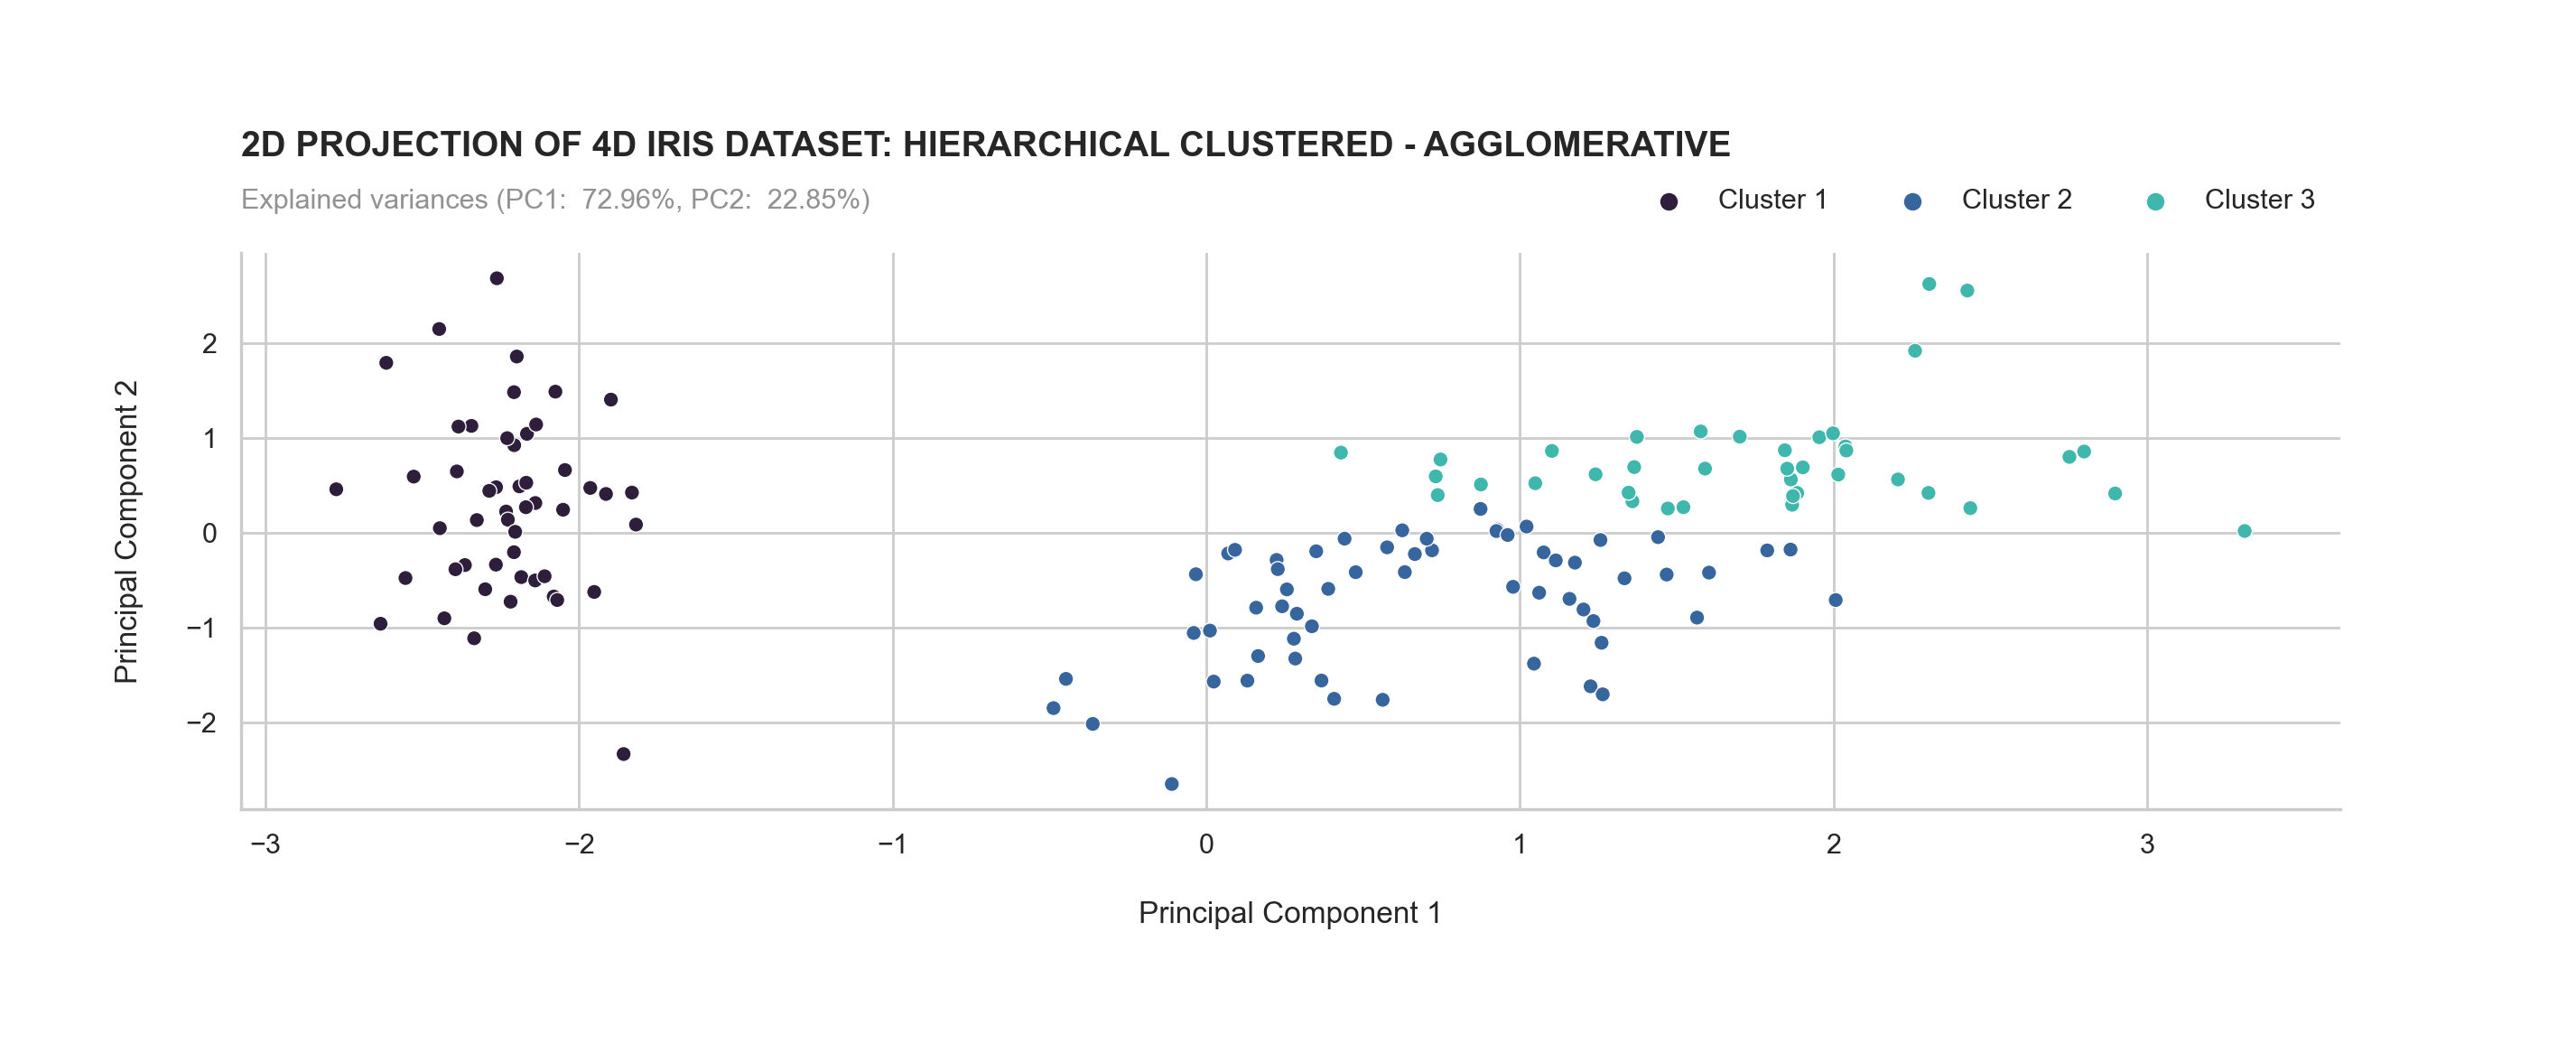

In [171]:
plot_scatterplot(
    data = df_iris_pca_transformed_agglomerative, x = 'pc1', y = 'pc2',
    hue = 'predicted_cluster', x_label = "Principal Component 1", y_label = "Principal Component 2",
    title = '2D projection of 4D Iris Dataset: Hierarchical clustered - Agglomerative', labels = ['Cluster 1', 'Cluster 2', 'Cluster 3'],
    subtitle = f"Explained variances (PC1: {var_pca_explainedvariance[0]: 1.2%}, PC2: {var_pca_explainedvariance[1]: 1.2%})",
);

#### Ground truth clusters

/home/cabrera/anaconda3/envs/dsa/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


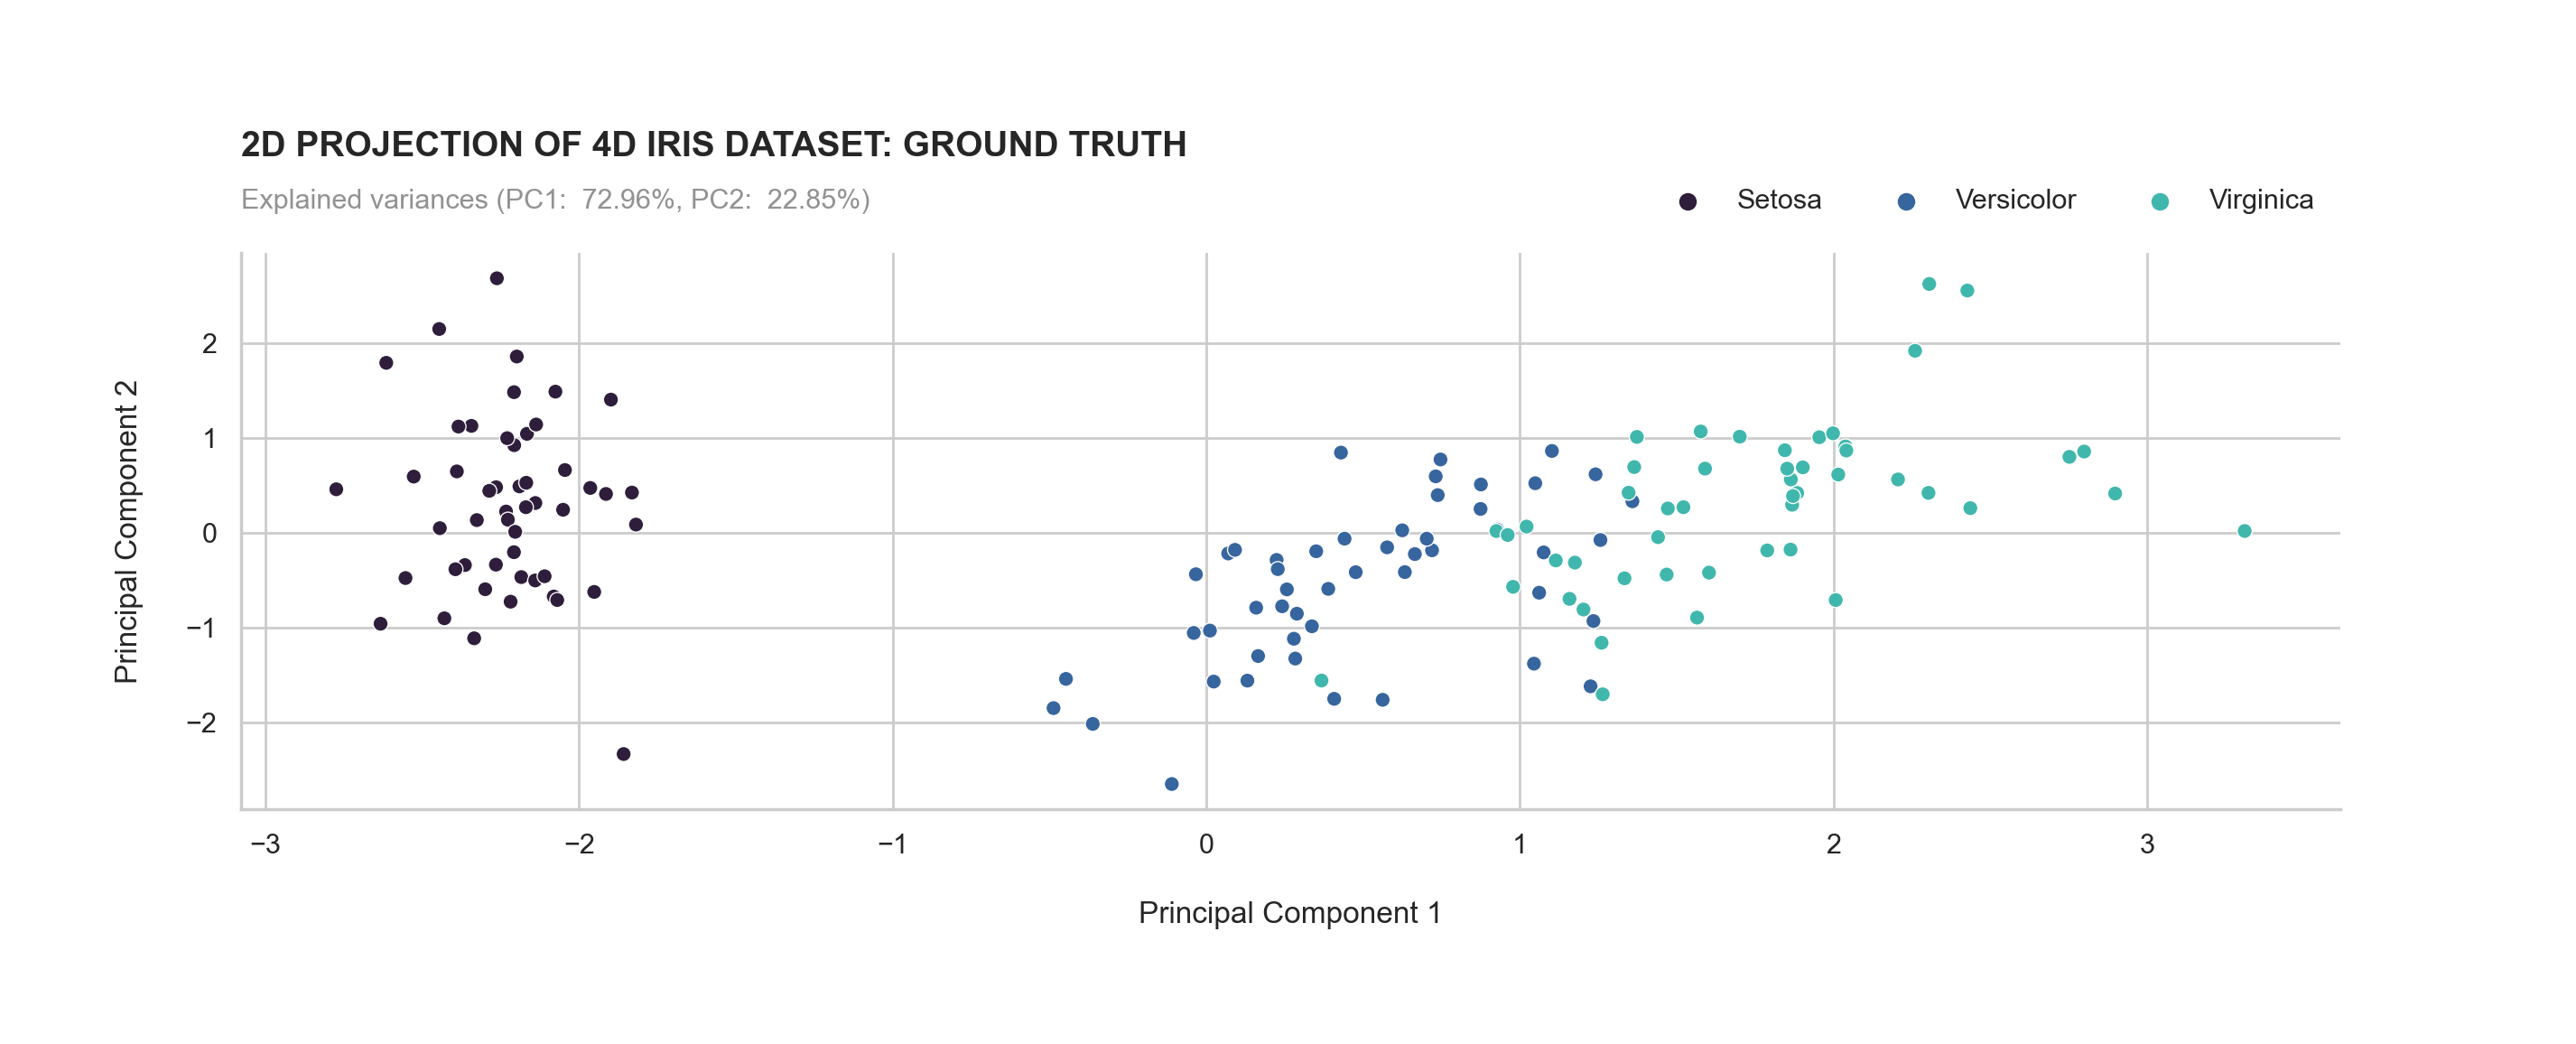

In [172]:
plot_scatterplot(
    data = df_iris_pca_transformed, x = 'pc1', y = 'pc2',
    hue = 'ground_truth_cluster', x_label = "Principal Component 1", y_label = "Principal Component 2",
    title = '2D projection of 4D Iris Dataset: Ground Truth', labels = [x.title() for x in var_ground_truth_clusters_value_names.values()],
    subtitle = f"Explained variances (PC1: {var_pca_explainedvariance[0]: 1.2%}, PC2: {var_pca_explainedvariance[1]: 1.2%})",
);

#### Metrics score visualization

In [173]:
var_clustering_evaluation_agglomerative = evaluate_clustering_result(
    X = var_X_pca_transformed,
    ari_labels_true = df_iris_pca_transformed_agglomerative['ground_truth_cluster'],
    ari_labels_pred = df_iris_pca_transformed_agglomerative['predicted_cluster'], )

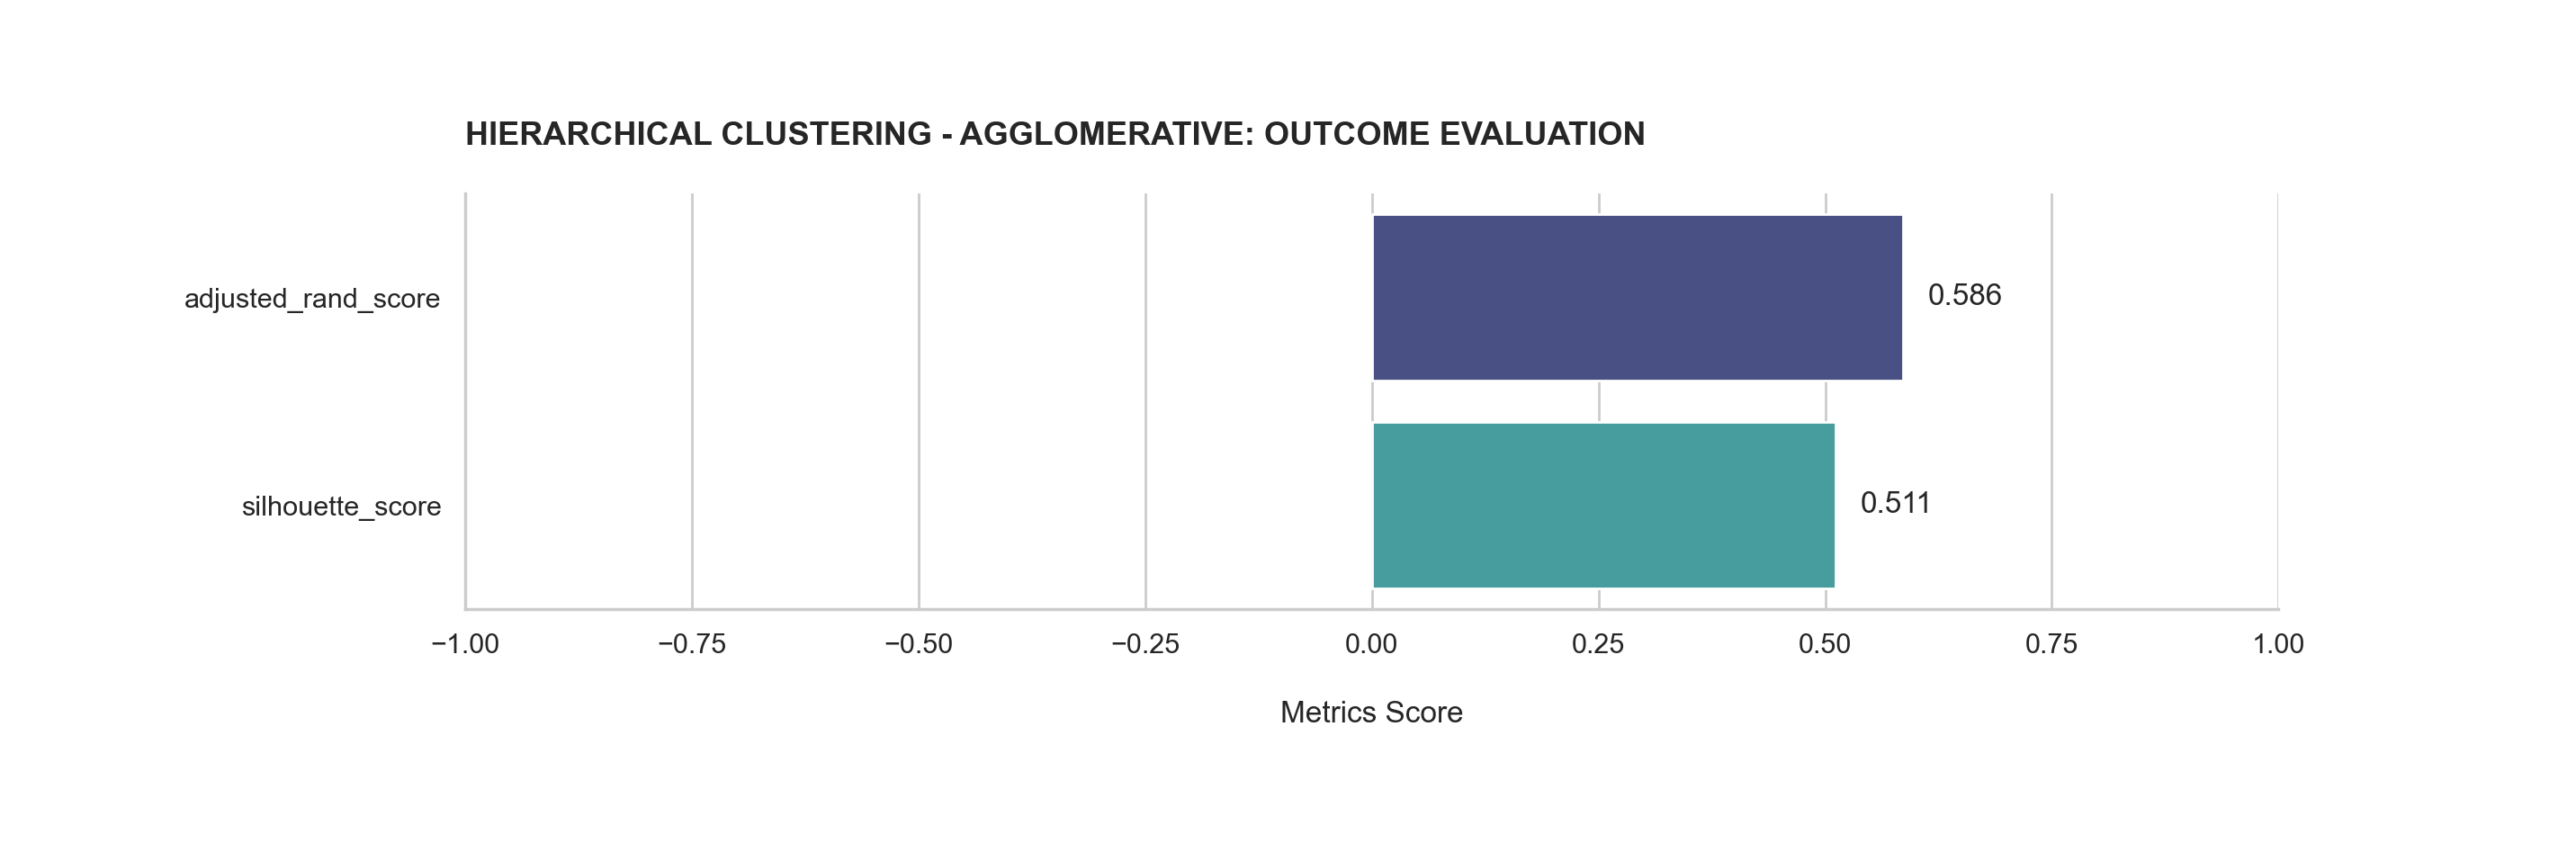

In [174]:
plot_barplot(
    data = (
        pd.DataFrame(
            index = var_clustering_evaluation_agglomerative.keys(),
            data = var_clustering_evaluation_agglomerative.values())
        .reset_index()
        .rename(columns = {'index' : 'metrics', 0 : 'score'})),
    x = 'score', y = 'metrics', figsize = (13, 3),
    x_label = 'Metrics Score', x_lim = (-1, 1),
    title = "Hierarchical Clustering - Agglomerative: Outcome Evaluation"
)